# TODO

In [1]:
# Simplify calculate area, compare_outline_complexity, and find_max_area_bias to read in evolving_lakes_gdf
# Change compare_outline_complexity to use geodesic area
# Use calculate_area function in lake_locations or FigS1_lake_reexamination_methods notebook?

Code to Figs. 2, 3, 4 of Sauthoff and others, 2024, *Journal*

This code requires a XX GB server or local memory

Written 2023-11-11 by W. Sauthoff (wsauthoff.github.io)

# Set up computing environment

In [39]:
# Import libraries
import datetime
import fiona
import geopandas as gpd
import glob
from IPython.display import clear_output
import math
from math import radians
import matplotlib
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.legend_handler import HandlerPatch, HandlerTuple
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import pandas as pd
from pathlib import Path
from pyproj import CRS, Geod, Transformer
import rioxarray
from shapely.geometry import MultiPolygon, Point, Polygon
from shapely.ops import unary_union

# Magic functions
%matplotlib widget

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_evolving_lakes/output/Figs234_lake_reexamination_results/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    OUTPUT_DIR_GIT = '/home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# Define utility functions
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

# Functions

In [3]:
# def timestamp_to_fractional_year(timestamp):
#     # Check if the year is a leap year
#     year = timestamp.year
#     if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
#         days_in_year = 366
#     else:
#         days_in_year = 365

#     # Calculate the day of the year
#     day_of_year = timestamp.timetuple().tm_yday

#     # Calculate the fractional year
#     fractional_year = year + (day_of_year - 1) / days_in_year
    
#     return fractional_year

# # # Example usage
# # timestamp = pd.Timestamp('2023-03-07 12:34:56')
# # fractional_year = timestamp_to_fractional_year(timestamp)
# # print(f"Fractional Year: {fractional_year}")

In [4]:
def compare_outline_complexity(lake_gdf):
    '''
    Calculate the perimeter-to-area ratio for a given lake in both the stationary outline and the 
    unary union of evolving outlines
    '''
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None

    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))

    # Calculating complexity - perimeter-to-area ratio
    stationary_complexity = stationary_outline.length / stationary_outline.area
    evolving_complexity = evolving_outlines_unary_union.length / evolving_outlines_unary_union.area
    complexity_ratio = evolving_complexity / stationary_complexity
    
    return {
        'lake_name': lake_name,
        'stationary_complexity': stationary_complexity,
        'evolving_complexity': evolving_complexity,
        'complexity_ratio': complexity_ratio
    }

In [5]:
def shoreline_development_factor(lake_gdf):
    '''
    Calculate the Shoreline Development Factor (SDF) for a given lake in both the stationary outline and the 
    unary union of evolving outlines. SDF is the ratio of the observed perimeter to the minimum possible
    perimeter (which would be a circle with the same area).
    
    SDF = P / (2 * sqrt(π * A)) where P is perimeter and A is area
    '''
    import math
    import geopandas as gpd
    import os
    from shapely.ops import unary_union
    
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry'].iloc[0]
    
    def calculate_sdf(geometry):
        """Helper function to calculate Shoreline Development Factor"""
        area = geometry.area
        perimeter = geometry.length
        # Calculate minimum perimeter (circumference of circle with same area)
        min_perimeter = 2 * math.sqrt(math.pi * area)
        # Calculate SDF
        sdf = perimeter / min_perimeter
        return sdf
    
    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None
        
    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    
    # Calculate SDF for both outlines
    stationary_sdf = calculate_sdf(stationary_outline)
    evolving_sdf = calculate_sdf(evolving_outlines_unary_union)
    sdf_ratio = evolving_sdf / stationary_sdf
    
    return {
        'lake_name': lake_name,
        'stationary_sdf': stationary_sdf,
        'evolving_sdf': evolving_sdf,
        'sdf_ratio': sdf_ratio
    }

## shoreline_development_factor_for_unions

In [6]:
def shoreline_development_factor_for_unions(lake_gdf):
    '''
    Calculate the Shoreline Development Factor (SDF) for a given lake in both the stationary outline and the 
    unary union of evolving outlines. SDF is the ratio of the observed perimeter to the minimum possible
    perimeter (which would be a circle with the same area).
    
    SDF = P / (2 * sqrt(π * A)) where P is perimeter and A is area
    '''
    
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry'].iloc[0]
    
    def calculate_sdf(geometry):
        """Helper function to calculate Shoreline Development Factor"""
        area = geometry.area
        perimeter = geometry.length
        # Calculate minimum perimeter (circumference of circle with same area)
        min_perimeter = 2 * math.sqrt(math.pi * area)
        # Calculate SDF
        sdf = perimeter / min_perimeter
        return sdf
    
    # Attempt to open evolving outlines geojson
    try:
        evolving_union = evolving_outlines_union_gdf[
            evolving_outlines_union_gdf['name'] == lake_name]['geometry'].iloc[0]
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"No union outline found for {lake_name}: {e}")
        return None
    
    # Calculate SDF for both outlines
    stationary_sdf = calculate_sdf(stationary_outline)
    evolving_union_sdf = calculate_sdf(evolving_union)
    sdf_ratio = evolving_union_sdf / stationary_sdf
    
    return {
        'lake_name': lake_name,
        'stationary_sdf': stationary_sdf,
        'evolving_sdf': evolving_union_sdf,
        'sdf_ratio': sdf_ratio
    }

In [7]:
def calculate_area(poly):
    '''
    Calculate geodesic are of polygon or multipolygon
    '''
    if poly is None or not poly.is_valid:
        return None
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:  # Ensure we're accessing the geometries properly
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

In [8]:
def find_max_area_bias(lake_gdf):
    '''

    '''
    lake_name = lake_gdf['name'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        # print(f"File for {lake_name} not found or error reading file: {e}")
        return None
        
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        # print(f"CSV file for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist

    # Find max area bias
    max_bias_area = max(geom_calcs_df['bias_area (m^2)'])
    
    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_union_gdf = evolving_outlines_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_union_gdf['area (m^2)'] = evolving_outlines_union_gdf['geometry'].apply(calculate_area)

    # Find area difference between stationary outline and evolving outlines unary union
    evolving_union_stationary_diff = evolving_outlines_union_gdf['area (m^2)'].iloc[0] - lake_gdf['area (m^2)'].iloc[0]
    
    return {
        'lake_name': lake_name,
        'max_bias_area': max_bias_area,
        'evolving_union_stationary_diff': evolving_union_stationary_diff
    }

In [9]:
def muliple_area_buffer(polygon, area_multiple, precision=100):
    """
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    :param polygon: Shapely Polygon object
    :param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    :param precision: Precision for the iterative process to find the buffer distance
    :return: Buffered Polygon

    # Example usage
    # Define a simple square polygon
    square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
    # Apply the function to find the buffered polygon area and bounds
    buffered_poly = muliple_area_buffer(square, 2)
    """
    original_area = polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    buffered_polygon = polygon

    while True:
        buffered_polygon = polygon.buffer(buffer_distance)
        if buffered_polygon.area >= target_area:
            break
        buffer_distance += precision
    
    # Convert to geodataframe
    buffered_polygon_gdf = gpd.GeoDataFrame({'geometry': [buffered_polygon]})

    return buffered_polygon

## plot_lake_groups_dV

In [10]:
def plot_lake_groups_dV(lake_groups):
    """
    Create multi-panel plots for groups of lakes showing spatial overview and volume changes.
    Lakes are arranged in rows of three plots of equal size, with valid data checking.
    
    Parameters:
    -----------
    lake_groups : list of tuples
        Each tuple contains (group_name, lake_list) where:
        - group_name: str, name of the lake group for file naming and identification
        - lake_list: list of str, names of lakes to be analyzed together
    stationary_outlines_gdf : GeoDataFrame
        Contains stationary lake outlines and metadata
    """
    os.makedirs(OUTPUT_DIR + '/figures/fig4/lake_groups', exist_ok=True)
    
    for group_idx, (group_name, lake_list) in enumerate(lake_groups):
        print(f"\nProcessing lake group: {group_name}")
        
        # Lists to store valid lake data
        valid_lakes = []
        evolving_outlines_gdfs = []
        geom_calcs_dfs = []
        lake_gdfs = []
        
        # First pass: collect all valid lake data
        for lake_name in lake_list:
            print(f"Checking data for {lake_name}...")
            
            # Get lake data from stationary outlines
            lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake_name]
            if lake_gdf.empty:
                print(f"Skipping {lake_name}: not found in stationary outlines")
                continue
                
            # Try loading evolving outlines
            try:
                evolving_outlines_gdf = gpd.read_file(os.path.join(
                    OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines',
                    f'{lake_name}.geojson'))
            except Exception as e:
                print(f"  Skipping {lake_name}: no evolving outlines file")
                continue
                
            # Try loading geometric calculations
            try:
                geom_calcs_df = pd.read_csv(os.path.join(
                    OUTPUT_DIR_GIT + '/geometric_calcs/compare_evolving_and_stationary_outlines',
                    f'{lake_name}.csv'))
                geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])
            except Exception as e:
                print(f"  Skipping {lake_name}: no geometric calculations file")
                continue
            
            # If we got here, all data is valid
            print(f"  Valid data found for {lake_name}")
            valid_lakes.append(lake_name)
            lake_gdfs.append(lake_gdf)
            evolving_outlines_gdfs.append(evolving_outlines_gdf)
            geom_calcs_dfs.append(geom_calcs_df)
        
        # Skip this group if no valid lakes found
        if not valid_lakes:
            print(f"Skipping group {group_name}: no valid lakes found")
            continue
            
        print(f"\nCreating plots for valid lakes in group {group_name}: {valid_lakes}")

        # Calculate plot layout (including space for combined plot)
        n_lakes = len(valid_lakes)
        n_plots = n_lakes + 1  # Add 1 for the combined plot
        n_rows = (n_plots + 2) // 3  # Integer division rounded up
        
        # Create figure
        fig = plt.figure(figsize=(15, 5*n_rows + 3))
        gs = fig.add_gridspec(n_rows + 1, 3, height_ratios=[1] + [1]*n_rows)
        
        # Main spatial overview panel
        ax_main = fig.add_subplot(gs[0, :])
        
        # Get combined extent for all valid lakes
        x_mins, x_maxs, y_mins, y_maxs = [], [], [], []
        
        for lake_gdf, evolving_outlines_gdf in zip(lake_gdfs, evolving_outlines_gdfs):
            # Load evolving outlines union for extent calculation
            lake_name = lake_gdf['name'].iloc[0]
            evolving_stationary_union_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[
                evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]
            
            # Get extent
            x_min, y_min, x_max, y_max = evolving_stationary_union_gdf['geometry'].bounds.iloc[0]
            buffer_dist = max(x_max - x_min, y_max - y_min) * 0.05
            x_mins.append(x_min - buffer_dist)
            x_maxs.append(x_max + buffer_dist)
            y_mins.append(y_min - buffer_dist)
            y_maxs.append(y_max + buffer_dist)
        
        # Set plot extent
        x_min, x_max = min(x_mins), max(x_maxs)
        y_min, y_max = min(y_mins), max(y_maxs)
        
        # Plot MOA background
        mask_x = (moa_highres_da.x >= x_min) & (moa_highres_da.x <= x_max)
        mask_y = (moa_highres_da.y >= y_min) & (moa_highres_da.y <= y_max)
        moa_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
        ax_main.imshow(moa_subset[0,:,:], cmap='gray', clim=[14000, 17000],
                      extent=[x_min, x_max, y_min, y_max])
        
        # Plot stationary outlines
        stationary_color = 'darkturquoise'
        for lake_gdf in lake_gdfs:
            lake_gdf.boundary.plot(ax=ax_main, color=stationary_color, linewidth=2)
        
        # Plot evolving outlines with time-based coloring
        cmap = plt.get_cmap('plasma')
        norm = plt.Normalize(mdates.date2num(mid_cyc_dates[0]), 
                           mdates.date2num(mid_cyc_dates[-1]))
        
        for evolving_outlines_gdf in evolving_outlines_gdfs:
            for idx, row in evolving_outlines_gdf.iterrows():
                color = cmap(norm(mdates.date2num(pd.to_datetime(row['midcyc_datetime']))))
                gpd.GeoSeries(row['geometry']).boundary.plot(
                    ax=ax_main, color=color, linewidth=1)

        # Format overview axes
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax_main.xaxis.set_major_formatter(ticks_x)
        ax_main.yaxis.set_major_formatter(ticks_y)
        ax_main.set_xlabel('x [km]')
        ax_main.set_ylabel('y [km]')

        # Create colorbar for overview
        m = plt.cm.ScalarMappable(cmap=cmap)
        m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))
        divider = make_axes_locatable(ax_main)
        cax = divider.append_axes('bottom', size='3%', pad=0.6)
        
        major_years = [2012, 2016, 2020, 2024]
        minor_years = list(range(2011, 2025))
        major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
        minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]
        
        cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
        cbar.set_ticks(major_dates)
        cbar.set_ticklabels(major_years)
        cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
        cbar.set_label('evolving outline year', labelpad=5)

        # Get y axis limits
        y_min, y_max = get_overall_y_limits(geom_calcs_dfs)
        
        # Create axes for all plots
        axes = []
        for idx in range(n_plots):
            row = (idx // 3) + 1
            col = idx % 3
            ax = fig.add_subplot(gs[row, col])
            axes.append(ax)
        
        # Plot individual lakes first
        for idx, (lake_name, geom_calcs_df) in enumerate(zip(valid_lakes, geom_calcs_dfs)):
            ax = axes[idx]
            ax.axhline(0, color='k', linestyle='--')
            
            dates = mdates.date2num(geom_calcs_df['midcyc_datetime'])
            
            # Stationary outline
            ax.plot(dates, 
                   np.cumsum(np.divide(geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)),
                   color=stationary_color, label='Stationary', linewidth=2)
            ax.scatter(dates, 
                   np.cumsum(np.divide(geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)),
                   color=stationary_color, s=5)

            # Store line segments for multi-colored line in legend
            onlake_lines = []
            for i, dt in enumerate(dates):
                x, y = 1, 1
                onlake_line, = ax.plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), linewidth=2)
                onlake_lines.append(onlake_line)

            # Evolving outlines (multi-colored line)
            x = dates
            y = np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)
            lc.set_linewidth(2)
            ax.add_collection(lc)
            ax.scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

            # Bias
            ax.plot(dates,
                   np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)),
                   color='r', label='Bias', linewidth=2)
            ax.scatter(dates,
                   np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)),
                   color='r', s=5)
                   
            # Format axes
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_major_locator(mdates.YearLocator(2))
            ax.xaxis.set_minor_locator(mdates.YearLocator())
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Year')
            ax.set_title(lake_name)

            # Set x and y axes limit
            ax.set_xlim(cyc_start_dates[0], cyc_end_dates[-1])
            ax.set_ylim(y_min, y_max)
            
            # Add legend to first plot only
            if idx == 0:
                stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=2)
                bias_line = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)
                legend = ax.legend([tuple(onlake_lines),
                                    stationary_line,
                                    bias_line],
                    ['evolving outlines', 
                     'stationary outline',
                     'bias (evolving - stationary)'], 
                    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
                    loc='upper right')

            # Handle y-axis formatting based on column position
            if idx % 3 == 0:  # Left column
                ax.set_ylabel('Cumulative dV [km$^3$]')
            else:  # Middle and right columns
                ax.set_yticklabels([])  # Remove y-axis tick labels

        # Plot combined data in the last panel
        ax = axes[-1]
        ax.set_ylim(y_min, y_max)
        ax.axhline(0, color='k', linestyle='--')
        
        # Combine and sum all geometric calculations
        if geom_calcs_dfs:
            combined_df = pd.concat(geom_calcs_dfs)
            summed_df = combined_df.groupby('midcyc_datetime').sum().reset_index()
            dates = mdates.date2num(summed_df['midcyc_datetime'])
        
            # Plot combined volume changes
            ax.plot(dates,
                np.cumsum(np.divide(summed_df['stationary_outline_dV_corr (m^3)'], 1e9)),
                color=stationary_color, linewidth=2)
            ax.scatter(dates,
                np.cumsum(np.divide(summed_df['stationary_outline_dV_corr (m^3)'], 1e9)),
                color=stationary_color, s=5)

            # Plot multi-colored line and scatter for data points
            x = dates
            y = np.cumsum(np.divide(summed_df['evolving_outlines_dV_corr (m^3)'], 1e9))
            
            # Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
            lc.set_linewidth(2)
            line = ax.add_collection(lc)
            scatter = ax.scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)
            
            ax.plot(dates,
                np.cumsum(np.divide(summed_df['bias_dV_corr (m^3)'], 1e9)),
                color='r', linewidth=2)
            ax.scatter(dates,
                np.cumsum(np.divide(summed_df['bias_dV_corr (m^3)'], 1e9)),
                color='r', linewidth=2, s=5)
        
        # Format combined plot axes
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        ax.xaxis.set_minor_locator(mdates.YearLocator())
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Year')
        ax.set_title('Summed')

        # Plot combined data in the last panel
        if (n_plots - 1) % 3 == 0:  # Check if the ax is in the leftmost column
            ax.set_ylabel('Cumulative dV [km$^3$]')
        else:  # Middle and right columns
            ax.set_yticklabels([])  # Remove y-axis tick labels

        # Save the figure using the group name
        sanitized_group_name = group_name.replace(' ', '_').replace('/', '_')
        plt.savefig(f'{OUTPUT_DIR}/fig4/lake_groups/{sanitized_group_name}.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        # plt.show()
        # Clear output
        clear_output(wait=True)

def get_overall_y_limits(geom_calcs_dfs):
    all_y_values = []
    
    for df in geom_calcs_dfs:
        # Get cumulative values for all three time series
        stationary_cumsum = np.cumsum(np.divide(df['stationary_outline_dV_corr (m^3)'], 1e9))
        evolving_cumsum = np.cumsum(np.divide(df['evolving_outlines_dV_corr (m^3)'], 1e9))
        bias_cumsum = np.cumsum(np.divide(df['bias_dV_corr (m^3)'], 1e9))
        
        # Extend list with all values
        all_y_values.extend(stationary_cumsum)
        all_y_values.extend(evolving_cumsum)
        all_y_values.extend(bias_cumsum)
    
    # Also include the combined plot values
    if geom_calcs_dfs:
        combined_df = pd.concat(geom_calcs_dfs)
        summed_df = combined_df.groupby('midcyc_datetime').sum().reset_index()
        
        stationary_cumsum = np.cumsum(np.divide(summed_df['stationary_outline_dV_corr (m^3)'], 1e9))
        evolving_cumsum = np.cumsum(np.divide(summed_df['evolving_outlines_dV_corr (m^3)'], 1e9))
        bias_cumsum = np.cumsum(np.divide(summed_df['bias_dV_corr (m^3)'], 1e9))
        
        all_y_values.extend(stationary_cumsum)
        all_y_values.extend(evolving_cumsum)
        all_y_values.extend(bias_cumsum)
    
    # Calculate limits with a small buffer (5% of range)
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    y_range = y_max - y_min
    buffer = y_range * 0.05
    
    return y_min - buffer, y_max + buffer

# Import datasets

In [54]:
# Import subglacial lake outlines 
stationary_outlines_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson')
revised_stationary_outlines_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')
evolving_outlines_union_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')
evolving_stationary_outlines_union_all_lakes_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson')

In [12]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

In [13]:
# Import cyc_dates
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'mid_cyc_dates', 'cyc_end_dates'])

# Store the cyc_dates columns as a np array with datetime64[ns] data type
cyc_start_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_start_dates']]
mid_cyc_dates = [np.datetime64(ts) for ts in cyc_dates['mid_cyc_dates']]
cyc_end_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_end_dates']]

In [14]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

In [15]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

/srv/conda/envs/notebook/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


# Statistics used in results section

In [15]:
# Combine all the evolving/stationary geometric calculation dataframes together to look at all time slices of all lakes that exhibit evolving outlines

# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
directory = 'output/lake_outlines/compare_evolving_and_stationary_outlines' #/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./

# Initialize an empty list to store the DataFrames
dataframes = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    # Check if the file is a CSV and not the file to ignore
    if filename.endswith('.csv') and filename != 'all_previously_identified_lakes.csv':  # Ignore summation dataframe
        file_path = os.path.join(directory, filename)  # Get full path of the file
        df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
        df['lake_name'] = filename[:-4]  # Remove the .csv extension
        dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into one DataFrame
all_compare_evolving_and_stationary_outlines_df = pd.concat(dataframes, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'output/lake_outlines/compare_evolving_and_stationary_outlines'

## Evolving outlines

In [16]:
# How many previously identified lakes were analyzed?
print('Analysis done on all previously identified lakes')
print(len(stationary_outlines_gdf), 'lakes reanalyzed')
print(len(revised_stationary_outlines_gdf), 
    'lakes analyzed in revised inventory due to Site_B and Site_C being combined into Site_BC')

Analysis done on all previously identified lakes
157 lakes reanalyzed
156 lakes analyzed in revised inventory due to Site_B and Site_C being combined into Site_BC


In [17]:
# How many lakes are missing CryoSat-2 SARIn coverage?
print(stationary_outlines_gdf[stationary_outlines_gdf['CS2_SARIn_start'] == '<NA>'].shape[0])
print(revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['CS2_SARIn_start'] == '<NA>'].shape[0])

98
98


In [18]:
# How many lakes are missing CryoSat-2 SARIn coverage during 2010.5-2013.75?
print(stationary_outlines_gdf[stationary_outlines_gdf['CS2_SARIn_start'] == '2013.75'].shape[0])
print(revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['CS2_SARIn_start'] == '2013.75'].shape[0])

6
6


In [19]:
# How many lakes are have complete CryoSat-2 SARIn coverage during pre-ICESat-2 era (2010.5)?
print(stationary_outlines_gdf[stationary_outlines_gdf['CS2_SARIn_start'] == '2010.5'].shape[0])
print(revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['CS2_SARIn_start'] == '2010.5'].shape[0])

53
52


In [20]:
# How many lakes exhibit no evolving outlines?
print(len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.txt')]),
      'lakes found to have no evolving outlines')

61 lakes found to have no evolving outlines


In [ ]:
# Get list of lakes with evolving outlines (remove .geojson extension)
evolving_outlines_dir = 'output/lake_outlines/evolving_outlines'
evolving_lakes = {
    Path(f).stem 
    for f in os.listdir(evolving_outlines_dir) 
    if f.endswith('.geojson')
}

# Filter the geodataframe
# Assuming the lake identifiers in the GeoDataFrame are in a column named 'lake_id'
evolving_mask = revised_stationary_outlines_gdf['name'].isin(evolving_lakes)

# Split into evolving and non-evolving lakes
stationary_outlines_of_evolving_lakes_gdf = revised_stationary_outlines_gdf[evolving_mask].copy()
stationary_outlines_of_non_evolving_lakes_gdf = revised_stationary_outlines_gdf[~evolving_mask].copy()

print(f"{len(stationary_outlines_of_evolving_lakes_gdf)} lakes found to have evolving outlines")
print(f"{len(stationary_outlines_of_non_evolving_lakes_gdf)} lakes found to have no evolving outlines")

In [ ]:
# Find names of lakes that do not have evolving outlines during the observational period

# Define the directories to compare
dir1 = 'output/lake_outlines/evolving_outlines'
dir2 = 'output/lake_outlines/compare_evolving_and_stationary_outlines'

# Helper function to get filenames without extensions
def filenames_without_extension(directory):
    return {os.path.splitext(file)[0] for file in os.listdir(directory)}

# List filenames in both directories without extensions
files_in_dir1 = filenames_without_extension(dir1)
files_in_dir2 = filenames_without_extension(dir2)

# Find files that are in dir1 but not in dir2
unique_to_dir1 = files_in_dir1.difference(files_in_dir2)

# Find files that are in dir2 but not in dir1
unique_to_dir2 = files_in_dir2.difference(files_in_dir1)

# Display the results
print("{} files unique to {}:".format(len(unique_to_dir1), dir1))
for file in unique_to_dir1:
    print(file)

print("\nFiles unique to {}:".format(dir2))
for file in unique_to_dir2:
    print(file)

In [ ]:
# What kind of CryoSat-2 SARIn coverage do these lakes have?
stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(unique_to_dir1)]['CS2_SARIn_start']

In [ ]:
# Compare lake outline complexity between evolving outlines union and stationary outline
results = []

for idx, row in stationary_outlines_gdf.iterrows():
    result = compare_outline_complexity(stationary_outlines_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['stationary_complexity'], results_df['evolving_complexity'], color='blue')

# Adding labels for each point
for i, row in results_df.iterrows():
    plt.text(row['stationary_complexity'], row['evolving_complexity'], row['lake_name'],
             fontsize=9, ha='right')

# Add a 1:1 line
max_complexity = max(results_df['stationary_complexity'].max(), results_df['evolving_complexity'].max())
plt.plot([0, max_complexity], [0, max_complexity], 'k--', label='1:1 Line')

plt.title('Comparison of Lake Outline Complexities')
plt.xlabel('stationary Outline Complexity (Perimeter/Area Ratio)')
plt.ylabel('Evolving Outlines Unary Union Complexity (Perimeter/Area Ratio)')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(results_df['complexity_ratio'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Complexity Ratio (Evolving/stationary)')
plt.xlabel('Complexity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
summary = results_df['complexity_ratio'].describe(percentiles=[.25, .5, .75])
five_number_summary = {
    'Minimum': summary['min'],
    '25th Percentile': summary['25%'],
    'Median': summary['50%'],
    '75th Percentile': summary['75%'],
    'Maximum': summary['max']
}
print(five_number_summary)

In [ ]:
# What percentage of the previously identified lakes have a higher complexity 
count_above = (results_df['evolving_complexity'] > results_df['stationary_complexity']).sum()
np.round(count_above/len(results_df), 2)

## Shoreline development factor

In [12]:
# Compare lake outline complexity between evolving outlines union and stationary outline
results = []

for idx, row in revised_stationary_outlines_gdf.iterrows():
    result = shoreline_development_factor_for_unions(revised_stationary_outlines_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.head()

No union outline found for Bindschadler_1: single positional indexer is out-of-bounds
No union outline found for Bindschadler_2: single positional indexer is out-of-bounds
No union outline found for Bindschadler_3: single positional indexer is out-of-bounds
No union outline found for Bindschadler_4: single positional indexer is out-of-bounds
No union outline found for Bindschadler_5: single positional indexer is out-of-bounds
No union outline found for Bindschadler_6: single positional indexer is out-of-bounds
No union outline found for Byrd_s1: single positional indexer is out-of-bounds
No union outline found for Byrd_s14: single positional indexer is out-of-bounds
No union outline found for Byrd_s3: single positional indexer is out-of-bounds
No union outline found for Byrd_s5: single positional indexer is out-of-bounds
No union outline found for Byrd_s7: single positional indexer is out-of-bounds
No union outline found for Cook_E1: single positional indexer is out-of-bounds
No union 

,lake_name,stationary_sdf,evolving_sdf,sdf_ratio
0,Byrd_1,1.211861,1.713690,1.414097
1,Byrd_2,1.127807,2.265174,2.008476
2,Byrd_s10,1.217724,2.422548,1.989406
3,Byrd_s11,1.038592,1.309893,1.261220
4,Byrd_s12,1.040131,1.174921,1.129589


In [13]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

results_df.sort_values('sdf_ratio', ascending=False)

,lake_name,stationary_sdf,evolving_sdf,sdf_ratio
93,Wilkes_2,1.025285,2.516213,2.454159
11,Byrd_s9,1.173855,2.788740,2.375711
5,Byrd_s13,1.064405,2.164106,2.033160
1,Byrd_2,1.127807,2.265174,2.008476
40,Kamb_12,1.039787,2.070239,1.991022
2,Byrd_s10,1.217724,2.422548,1.989406
14,David_s1,1.009653,1.948084,1.929458
28,Foundation_8,1.060684,2.045482,1.928456
64,Rec1,1.748860,3.325671,1.901623
32,Institute_E1,1.053151,1.996513,1.895752


In [15]:
# Count rows where sdf_ratio > 1.25
count = (results_df['sdf_ratio'] > 1.25).sum()
count

KeyError: 'sdf_ratio'

## active area

In [ ]:
# Main loop to process each lake and store the results in a DataFrame
results = []

for idx, row in stationary_outlines_gdf.iterrows():
    result = find_max_area_bias(stationary_outlines_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

In [ ]:
# What proportion of lakes have an individual time slice area that is larger that the stationary outline?
neg_count = results_df[results_df['max_bias_area'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

In [ ]:
# What proportion of lakes have an evolving outlines unary union that is larger that the stationary outline?
neg_count = results_df[results_df['evolving_union_stationary_diff'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

In [ ]:
# What proportion of time slices have an abs(stationary_outline_region_dh) > abs(evolving_outlines_region_dh) 
# when there is an evolving outline (otherwise rows without evolving outlines with zero for evolving_outlines_region_dh
# would distort proportion

# Filter the DataFrame to include only rows where 'evolving_outlines_region_dh (m)' > 0
filtered_df = all_compare_evolving_and_stationary_outlines_df[
    all_compare_evolving_and_stationary_outlines_df['evolving_outlines_region_dh (m)'] > 0]

# Calculate the absolute values for the filtered data
# abs_stationary = abs(filtered_df['stationary_outline_dh (m)'])
abs_stationary = abs(filtered_df['stationary_outline_dh (m)'])
abs_evolving = abs(filtered_df['evolving_outlines_region_dh (m)'])

# Create a boolean series where True indicates abs(stationary) > abs(evolving)
condition = abs_stationary > abs_evolving

# Calculate the proportion of True values in the condition
proportion = condition.mean()

print("Proportion of rows where abs(stationary_outline_dh (m)) > abs(evolving_outlines_region_dh (m)):", np.round(proportion, 2))

In [ ]:
# Find the five-number summary of the area bias
variable = all_compare_evolving_and_stationary_outlines_df['bias_area (m^2)']

# Calculate the five-number summary
min_value = np.round(np.nanmin(variable)/1e6, 2)
q1 = np.round(np.nanpercentile(variable, 25)/1e6, 2)
median = np.round(np.nanmedian(variable)/1e6, 2)
q3 = np.round(np.nanpercentile(variable, 75)/1e6, 2)
max_value = np.round(np.nanmax(variable)/1e6, 2)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

In [ ]:
# Finding the index of the maximum value in the 'bias_area (m^2)' column
max_index = all_compare_evolving_and_stationary_outlines_df['bias_area (m^2)'].idxmax()
min_index = all_compare_evolving_and_stationary_outlines_df['bias_area (m^2)'].idxmax()

# Retrieving the row with the maximum value
print(all_compare_evolving_and_stationary_outlines_df.loc[max_index])
# print(all_compare_evolving_and_stationary_outlines_df.loc[min_index])

In [ ]:
# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines/*.geojson'
files = glob.glob(folder_path)

levels = []
extents = []

# Read each GeoJSON file and extract the first 'level' value
for file in files:
    gdf = gpd.read_file(file)
    # Make sure the GeoDataFrame is not empty and contains a 'level' column
    if not gdf.empty and 'level' in gdf.columns:
        # Storing first value of geodataframe because it was sorted by levels in ascending level (i.e., the smallest level in first row)
        first_level_value = gdf.iloc[0]['level']
        levels.append(first_level_value)
        first_extent_value = gdf.iloc[0]['area_multiple_search_extent']
        extents.append(first_extent_value)

# Convert the list of levels to a numpy array for statistical analysis
levels_array = np.array(levels)
extents_array = np.array(extents)

# Calculate the five-number summary
min_value = np.min(levels_array)
q1 = np.percentile(levels_array, 25)
median = np.median(levels_array)
q3 = np.percentile(levels_array, 75)
max_value = np.max(levels_array)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

# Calculate the five-number summary
min_value = np.min(extents_array)
q1 = np.percentile(extents_array, 25)
median = np.median(extents_array)
q3 = np.percentile(extents_array, 75)
max_value = np.max(extents_array)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

In [ ]:
# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines/*.geojson'
files = glob.glob(folder_path)

data = []

# Read each GeoJSON file and extract the necessary information
for file in files:
    file_name_with_extension = os.path.basename(file)
    file_name = os.path.splitext(file_name_with_extension)[0]  # Remove the file extension
    gdf = gpd.read_file(file)
    # Make sure the GeoDataFrame is not empty and contains 'level' and 'area_multiple_search_extent' columns
    if not gdf.empty and 'level' in gdf.columns and 'area_multiple_search_extent' in gdf.columns:
        # Extracting the first values from the GeoDataFrame
        first_level_value = gdf.iloc[0]['level']
        first_extent_value = gdf.iloc[0]['area_multiple_search_extent']
        data.append([file_name, first_level_value, first_extent_value])

# Creating a DataFrame with the collected data
df = pd.DataFrame(data, columns=['name', 'level', 'search_extent'])

# Converting the DataFrame to a GeoDataFrame
gdf_result = gpd.GeoDataFrame(df)

# Sorting the GeoDataFrame by 'search_extent' column in descending order
gdf_result_sorted = gdf_result.sort_values(by='search_extent', ascending=False)

In [ ]:
gdf_result_sorted[gdf_result_sorted['search_extent' == 15.0]]

In [ ]:
gdf_result_sorted

In [ ]:
np.sum(extents_array > 15)

In [ ]:
# Five number summary of the area multiple search extent


## dh_corr

## dV_corr

In [ ]:
# Set the directory where your CSV files are located
folder_path = 'output/lake_outlines/compare_evolving_and_stationary_outlines'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize lists to store the results for each condition, both, and either
results_greater_than = []
results_less_than = []
results_both_conditions = []
results_either_condition = []

# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a DataFrame
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Filter out rows where 'evolving_outlines_dV_corr (m^3)' is 0
    filtered_df = df[df['evolving_outlines_dV_corr (m^3)'] != 0]

    # Check conditions
    condition_greater_than = (filtered_df['evolving_outlines_dV_corr (m^3)'] > 1.1 * filtered_df['stationary_outline_dV_corr (m^3)'])
    condition_less_than = (filtered_df['evolving_outlines_dV_corr (m^3)'] < 0.9 * filtered_df['stationary_outline_dV_corr (m^3)'])
    # condition_greater_than = (filtered_df['evolving_outlines_dV_corr (m^3)'] > 1.1 * filtered_df['stationary_outline_dV_corr (m^3)'])
    # condition_less_than = (filtered_df['evolving_outlines_dV_corr (m^3)'] < 0.9 * filtered_df['stationary_outline_dV_corr (m^3)'])

    # Combined conditions for both and either
    condition_both = condition_greater_than.any() & condition_less_than.any()
    condition_either = condition_greater_than | condition_less_than

    # Append results based on conditions
    results_greater_than.append(condition_greater_than.any())
    results_less_than.append(condition_less_than.any())
    results_both_conditions.append(condition_both.any())
    results_either_condition.append(condition_either.any())

# Calculate the proportion of files that meet each condition
proportion_greater_than = sum(results_greater_than) / len(results_greater_than)
proportion_less_than = sum(results_less_than) / len(results_less_than)
proportion_both_conditions = sum(results_both_conditions) / len(results_both_conditions)
proportion_either_condition = sum(results_either_condition) / len(results_either_condition)

# Print out the results
print(f"Lakes meeting the condition 1 (greater than 110%): {sum(results_greater_than)} ({proportion_greater_than:.2f})")
print(f"Lakes meeting the condition 2 (less than 90%): {sum(results_less_than)} ({proportion_less_than:.2f})")
print(f"Lakes meeting either condition: {sum(results_either_condition)} ({proportion_either_condition:.2f})")
print(f"Lakes meeting both conditions: {sum(results_both_conditions)} ({proportion_both_conditions:.2f})")

In [ ]:
# What proportion of all timeslices have evolving outlines dV greater or less than 10% different from stationary outline dV

# Filter out rows where 'evolving_outlines_dV_corr (m^3)' is 0
filtered_df = all_compare_evolving_and_stationary_outlines_df[
    all_compare_evolving_and_stationary_outlines_df['evolving_outlines_dV_corr (m^3)'] != 0]

# Define the separate conditions
condition1 = (filtered_df['evolving_outlines_dV_corr (m^3)'].abs() > 
              1.1 * filtered_df['stationary_outline_dV_corr (m^3)'].abs())
condition2 = (filtered_df['evolving_outlines_dV_corr (m^3)'].abs() < 
              0.9 * filtered_df['stationary_outline_dV_corr (m^3)'].abs())
# condition1 = (filtered_df['evolving_outlines_dV_corr (m^3)'].abs() > 
#               1.1 * filtered_df['stationary_outline_dV_corr (m^3)'].abs())
# condition2 = (filtered_df['evolving_outlines_dV_corr (m^3)'].abs() < 
#               0.9 * filtered_df['stationary_outline_dV_corr (m^3)'].abs())

# Condition where neither condition is met
either_condition = (condition1 | condition2)

# Condition where neither condition is met
neither_condition = ~(condition1 | condition2)

# Condition where both conditions are met
both_conditions = condition1 & condition2

# Count the number of rows meeting each condition
num_rows_condition1 = condition1.sum()
num_rows_condition2 = condition2.sum()
num_rows_either_condition = either_condition.sum()
num_rows_neither_condition = neither_condition.sum()
num_rows_both_conditions = both_conditions.sum()

# Calculate proportions based on the length of filtered_df
proportion_condition1 = num_rows_condition1 / len(filtered_df)
proportion_condition2 = num_rows_condition2 / len(filtered_df)
proportion_either_condition = num_rows_either_condition / len(filtered_df)
proportion_neither_condition = num_rows_neither_condition / len(filtered_df)
proportion_both_conditions = num_rows_both_conditions / len(filtered_df)  # Conditions are mutually exclusive, so should be zero
sum_of_proportions = np.sum([proportion_condition1, proportion_condition2, proportion_both_conditions, proportion_neither_condition])

# Print out the results
print(f"Proportion of time slices meeting condition 1 (greater than 110%): {np.round(proportion_condition1, 2)}")
print(f"Proportion of time slices meeting condition 2 (less than 90%): {np.round(proportion_condition2, 2)}")
print(f"Proportion of time slices meeting either conditions: {np.round(proportion_either_condition, 2)}")
print(f"Proportion of time slices meeting neither condition: {np.round(proportion_neither_condition, 2)}")
print(f"Proportion of time slices meeting both conditions: {np.round(proportion_both_conditions, 2)}")
print(f"Sums of proportions: {np.round(sum_of_proportions, 2)}")

In [ ]:
# What is the distribution of the bias as a percentage of the stationary outline dV

# Filter out rows where 'evolving_outlines_dV_corr (m^3)' is 0
filtered_df = all_compare_evolving_and_stationary_outlines_df[
    all_compare_evolving_and_stationary_outlines_df['evolving_outlines_dV_corr (m^3)'] != 0]

# Assuming filtered_df is already defined as given
# Calculate the percentage of 'bias_dV_corr (m^3)' relative to 'stationary_outline_dV_corr (m^3)'
percentages = (filtered_df['bias_dV_corr (m^3)'] / filtered_df['stationary_outline_dV_corr (m^3)']) * 100
# percentages = (filtered_df['bias_dV_corr (m^3)'] / filtered_df['stationary_outline_dV_corr (m^3)']) * 100

# Calculate the five-number summary of these percentages
five_number_summary = percentages.describe(percentiles=[.25, .5, .75])

# Print the five-number summary
print("Five-number summary of the percentages:")
print(f"Minimum: {five_number_summary['min']:.2f}%")
print(f"25th Percentile: {five_number_summary['25%']:.2f}%")
print(f"Median: {five_number_summary['50%']:.2f}%")
print(f"75th Percentile: {five_number_summary['75%']:.2f}%")
print(f"Maximum: {five_number_summary['max']:.2f}%")

# Figures

## Fig. 2

In [1]:
# Select lakes to be included in plot
selected_lakes = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(['ConwaySubglacialLake', 'David_s1', 'Slessor_23'])]
desired_order = ['ConwaySubglacialLake', 'David_s1', 'Slessor_23']
stationary_outlines_gdf_filtered = gpd.GeoDataFrame(pd.concat([selected_lakes[selected_lakes['name'] == name] for name in desired_order]))

# Number of rows and columns
nrows, ncols = 4, 3

# Create a 4x3 grid of plots (4 metrics, 3 lakes per metric)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20), constrained_layout=True)

# Define color that will be reused
stationary_outline_color  = 'darkturquoise'

for row in range(1, nrows):
    # Share y-axis within each row but not between rows
    for col in range(ncols):
        axs[row, col].sharey(axs[row, 0])

# Pick colormap and normalize to mid_cyc_dates
cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
norm = plt.Normalize(mdates.date2num(mid_cyc_dates[0]), 
                    mdates.date2num(mid_cyc_dates[-1]))

for idx, (lake_idx, lake) in enumerate(stationary_outlines_gdf_filtered.iterrows()):
    # Select the row by index and convert it to a GeoDataFrame
    lake_gdf = stationary_outlines_gdf_filtered.loc[[lake_idx]]
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry']
    print(f"\nProcessing lake: {lake_name}")
    
    # Attempt to open the evolving outlines GeoJSON file
    try:
        evolving_outlines_gdf = gpd.read_file(OUTPUT_DIR_GIT + 
                                              '/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        continue  # Skip the rest of the function if the file doesn't exist
    
    # Attempt to open the geometric calculations CSV file
    try:
        evolving_geom_calcs_df = pd.read_csv(OUTPUT_DIR_GIT + 
                                    '/geometric_calcs/evolving_outlines_geom_calc/{}.csv'.format(lake_name))
        evolving_union_geom_calcs_df = pd.read_csv(OUTPUT_DIR_GIT + 
                                    '/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes/{}.csv'.format(lake_name))
        stationary_geom_calcs_df = pd.read_csv(OUTPUT_DIR_GIT + 
                                    '/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes/{}.csv'.format(lake_name))
    except FileNotFoundError:
        print(f"CSV file for {lake_name} not found. Skipping...")
        continue  # Skip the rest of the function if the file doesn't exist
    
    # Convert of strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

    
    # Panel - evolving outlines ------------------------------------------------------
    
    # Use evolving-stationary union outline to find max bounds of plot
    evolving_stationary_union_gdf = evolving_stationary_outlines_union_all_lakes_gdf[
        evolving_stationary_outlines_union_all_lakes_gdf['name'] == lake_name]
    x_min, y_min, x_max, y_max = evolving_stationary_union_gdf.bounds.iloc[0]

    # Make plots a uniform size
    # Make x_min, y_min, x_max, and y_max define a square area centered at the original midpoints
    # Calculate the midpoints of the current bounds
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    
    # Calculate the current spans of the x and y dimensions
    x_span = x_max - x_min
    y_span = y_max - y_min
    
    # Determine the maximum span to ensure square dimensions
    max_span = max(x_span, y_span)
    
    # Update the min and max values to match the new span, keeping the midpoint the same
    x_min = x_mid - max_span / 2
    x_max = x_mid + max_span / 2
    y_min = y_mid - max_span / 2
    y_max = y_mid + max_span / 2
    
    buffer_frac = 0.35
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac

    # Plot MOA surface imagery
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    axs[0,idx].imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
    # Use for loop to store each time slice as line segment to use in legend
    # And plot each evolving outline in the geodataframe color by date
    lines = []  # list of lines to be used for the legend
    for dt_idx, dt in enumerate(mid_cyc_dates):
        x = 1; y = 1
        line, = axs[0,idx].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[dt_idx]))))
        lines.append(line)
        
        # Filter rows that match the current time slice
        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    
        # Plotting the subset if not empty
        if not evolving_outlines_gdf_dt_sub.empty:
            evolving_outlines_gdf_dt_sub.boundary.plot(ax=axs[0,idx], 
                color=cmap(norm(mdates.date2num(mid_cyc_dates[dt_idx]))), linewidth=1)
    
    # Plot stationary outline
    stationary_outlines_gdf['geometry'].boundary.plot(ax=axs[0,idx], color=stationary_outline_color, linewidth=2)

    # Import evolving_outlines_union_gdf and plot
    evolving_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]
    evolving_union_gdf.boundary.plot(ax=axs[0,idx], color='k', linestyle='dotted', linewidth=2)

    # Plot inset map
    axIns = axs[0,idx].inset_axes([0.01, -0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    # Plot star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=2, color='k', s=30, zorder=3)

    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axs[0,idx].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axs[0,idx].yaxis.set_major_formatter(ticks_y)
    
    # Set axes limits
    axs[0,idx].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))


    # Panel - Active area ---------------------------------------------
    
    # Plot horizontal zero line for reference
    axs[1,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outline and evolving outlines unary union areas
    axs[1,idx].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
        color=stationary_outline_color, linestyle='solid', linewidth=2)
    axs[1,idx].axhline(np.divide(evolving_union_gdf['area (m^2)'].iloc[0], 1e6), 
        color='k', linestyle='dotted', linewidth=2)

    # Plot multi-colored line and scatter for data points
    x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y = np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = axs[1,idx].add_collection(lc)
    scatter = axs[1,idx].scatter(x, y, c=x, cmap=cmap, s=9, norm=norm, zorder=2)
    
    # # Get the maximum y value across all data for this lake
    # if idx == 0:
    #     max_y = max(
    #         np.divide(lake_gdf['area (m^2)'], 1e6).values[0],
    #         np.divide(evolving_outlines_union_gdf['area (m^2)'], 1e6).values[0],
    #         np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6).max()
    #     )
    
    # # Set y limit with padding above the maximum value to avoid data plotting behind legend
    # ax[1,idx].set_ylim(bottom=None, top=max_y * 1.3)
    
    # Panel - Cumulative dh/dt -------------------------------------------------------
    
    # Plot horizontal zero line for reference
    axs[2,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)

    # Plot stationary outlines off-lake region dh
    axs[2,idx].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']),
        np.cumsum(stationary_geom_calcs_df['stationary_outline_region_dh (m)']),
        color='lightgray', linestyle='solid', linewidth=2)
    axs[2,idx].scatter(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']),
        np.cumsum(stationary_geom_calcs_df['stationary_outline_region_dh (m)']),
        color='lightgray', linestyle='solid', linewidth=2, s=5)

    # Plot evolving outlines off-lake region dh
    axs[2,idx].plot(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(evolving_union_geom_calcs_df['stationary_outline_region_dh (m)']), color='dimgray', 
            linestyle='solid', linewidth=2)
    axs[2,idx].scatter(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(evolving_union_geom_calcs_df['stationary_outline_region_dh (m)']), color='dimgray', 
            linestyle='solid', linewidth=2, s=5)
    
    # Plot stationary outline time series
    axs[2,idx].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), 
            color=stationary_outline_color, linestyle='solid', linewidth=2)
    axs[2,idx].scatter(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), 
            color=stationary_outline_color, linestyle='solid', linewidth=2, s=5)

    # Plot multi-colored line and scatter for data points
    x = mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime'])
    y = np.cumsum(evolving_union_geom_calcs_df['stationary_outline_dh_corr (m)'])
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = axs[2,idx].add_collection(lc)
    scatter = axs[2,idx].scatter(x, y, c=x, cmap=cmap, s=9, norm=norm, zorder=2)

    # Plot evolving outlines union outline time series
    axs[2,idx].plot(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(evolving_union_geom_calcs_df['stationary_outline_dh_corr (m)']), 
            color='k', linestyle='dashed', linewidth=2)
    axs[2,idx].scatter(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(evolving_union_geom_calcs_df['stationary_outline_dh_corr (m)']), 
            color='k', linestyle='dashed', linewidth=2, s=5)
    
    # Plot bias
    axs[2,idx].plot(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']),
        np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)'] - 
        stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), 
        color='red', linestyle='solid', linewidth=2)
    axs[2,idx].scatter(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']),
        np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)'] - 
        stationary_geom_calcs_df['stationary_outline_dh_corr (m)']),
        color='red', linestyle='solid', linewidth=2, s=5)


    # Panel - Cumulative dV/dt --------------------------------------------------
    
    # Plot horizontal line at zero for reference
    axs[3,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outline time series
    axs[3,idx].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
        color=stationary_outline_color, linestyle='solid', linewidth=2)
    axs[3,idx].scatter(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
        color=stationary_outline_color, linestyle='solid', linewidth=2, s=5)

    # Plot multi-colored line and scatter for data points
    x = mdates.date2num(evolving_geom_calcs_df['midcyc_datetime'])
    y = np.cumsum(np.divide(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = axs[3,idx].add_collection(lc)
    scatter = axs[3,idx].scatter(x, y, c=x, cmap=cmap, s=9, norm=norm, zorder=2)

    # Plot evolving outlines union outline time series
    axs[3,idx].plot(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(np.divide(evolving_union_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
            color='k', linestyle='dashed', linewidth=2)
    axs[3,idx].scatter(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(np.divide(evolving_union_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
            color='k', linestyle='dashed', linewidth=2, s=5)
    
    # Plot bias
    axs[3,idx].plot(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide((evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'] -
                            stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9)), 
            color='red', linestyle='solid', linewidth=2)
    axs[3,idx].scatter(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide((evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'] -
                            stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9)), 
            color='red', linestyle='solid', linewidth=2, s=5)

# Add colorbar, legends, and titles
idx=0  # Add colorbar and legends only to first row of plots

# Create colorbar
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))
cax = inset_axes(axs[0,idx],
                 width='62%',
                 height='3%',
                 loc='lower left',
                 bbox_to_anchor=[0.33, 0.12, 1, 1],  # [left, bottom, width, height]
                 bbox_transform=axs[0,idx].transAxes,
                 borderpad=0)

# Define major and minor years
major_years = [2012, 2014, 2016, 2018, 2020, 2022, 2024]
minor_years = list(range(2011, 2025))
major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]

cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_ticks(major_dates)
cbar.set_ticklabels(major_years)
cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
cbar.set_label('evolving outline year', size=12, labelpad=3)

# Add legends
stationary_line = plt.Line2D([], [], color=stationary_outline_color, linestyle='solid', linewidth=2)
evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=2)

legend = axs[0,idx].legend([tuple(lines), 
                           evolving_union_line, 
                           stationary_line], 
    ['evolving outlines',
     'evolving outlines union',
     'stationary outline'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')

legend = axs[1,idx].legend(
    [tuple(lines), 
     evolving_union_line, 
     stationary_line],
    ['evolving outlines', 
     'evolving outlines union', 
     'stationary outline'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')

evolving_region = plt.Line2D([], [], color='dimgray', linestyle='solid', linewidth=2)
stationary_region = plt.Line2D([], [], color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

legend = axs[2,idx].legend(
    [evolving_region,
     stationary_region,
     tuple(lines),
     evolving_union_line, 
     stationary_line,  
     bias],
    ['evolving outlines region',
     'stationary outline region',
     'evolving outlines',
     'evolving outlines union', 
     'stationary outline', 
     'bias (evolving − stationary)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')

# Add legend
legend = axs[3,idx].legend(
    [tuple(lines),
     evolving_union_line,
     stationary_line,
     bias],
    ['evolving outlines',
     'evolving outlines union', 
     'stationary outline',
     'bias (evolving − stationary)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')

# Set font sizes for all plots
TICK_SIZE = 14
LABEL_SIZE = 18

# Set common font sizes and axis labels
for i in range(nrows):
    for j in range(ncols):
        # Set tick sizes for all plots
        axs[i,j].tick_params(axis='both', labelsize=TICK_SIZE)

        # Add subplot labels (a, b, c, etc.)
        axs[i,j].text(0.02, 0.98, chr(97 + i*2 + j), transform=axs[i,j].transAxes, 
                     fontsize=20, va='top', ha='left')

        # Configure row-specific settings
        if i == 0:
            axs[i,j].set_xlabel('X [km]', size=LABEL_SIZE)
        if i == 3:
            axs[i,j].set_xlabel('year', size=LABEL_SIZE)
        if 0 < i < 4:
            axs[i,j].xaxis.set_major_locator(mdates.YearLocator(base=2))
            axs[i,j].xaxis.set_minor_locator(mdates.YearLocator(base=1))
            axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        if j == 0:  # Leftmost column labels
            y_labels = ['Y [km]', 'active area [km$^2$]', 'cumulative dh [m]', 'cumulative dV [km$^3$]']
            axs[i,j].set_ylabel(y_labels[i], size=LABEL_SIZE)
        # Do not display redundant tick labels
        if 0 < i < 3:
            axs[i,j].set_xticklabels([])
        if i > 0:
            # Set x-axis limits
            axs[i,j].set(xlim=(cyc_dates['cyc_start_dates'].iloc[1], cyc_dates['cyc_end_dates'].iloc[-1]))
            if j > 0:
                axs[i,j].tick_params(axis='y', which='both', labelleft=False)
            else:
                axs[i,j].tick_params(axis='y', which='both', labelleft=True)

# Clear output
clear_output()

# Save and close plot
# plt.savefig(OUTPUT_DIR + 'Fig2_lake_reexamination_results.png', dpi=300, bbox_inches='tight')
# plt.close()
plt.show()

NameError: name 'stationary_outlines_gdf' is not defined

## Fig. 3

In [17]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 9,
    'axes.labelsize': 10,
    'axes.titlesize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
})

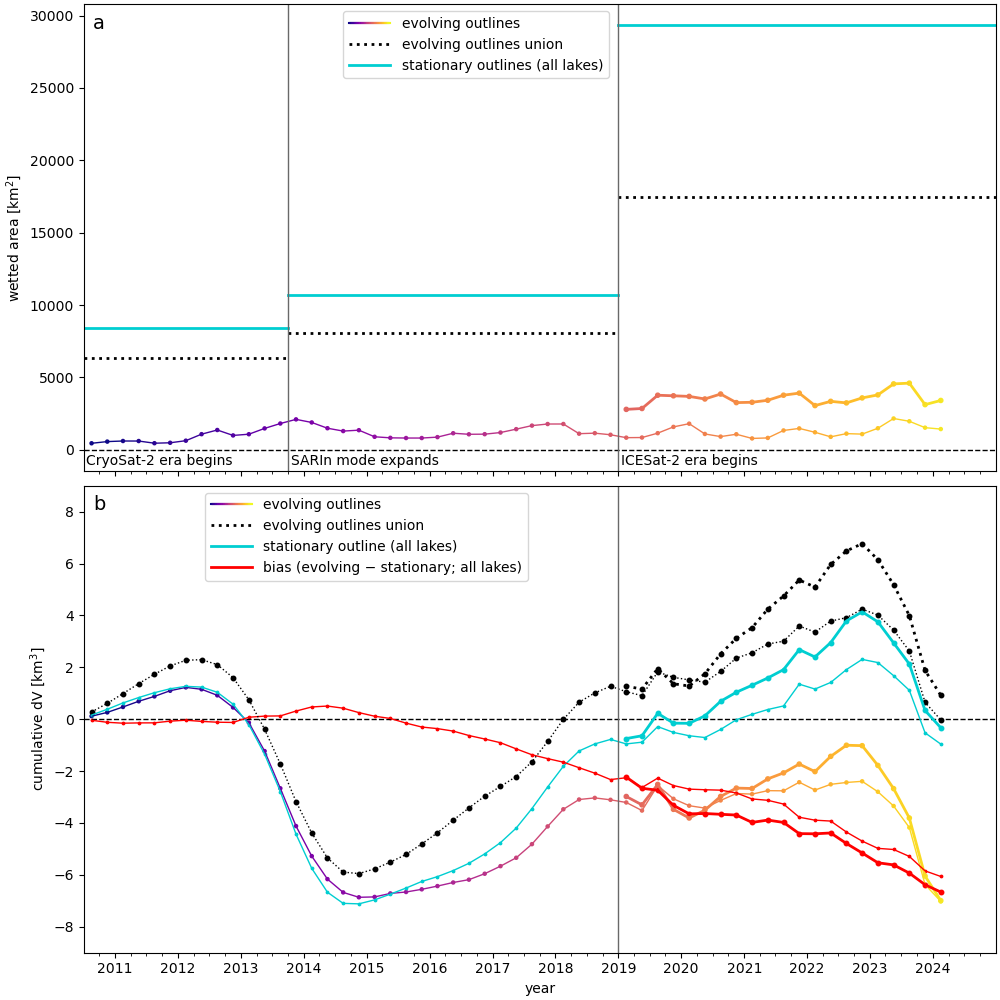

In [32]:
# Boolean controls one which curves are plotted

# incl_stationary_evolving_union = True
incl_stationary_evolving_union = False

# incl_lakes_with_activity_slices = True
incl_lakes_with_activity_slices = False

# Create a 2x1 grid of plots
nrows, ncols = 2, 1

# Setup figure
fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(10, 10), constrained_layout=True)

# Define colors and linestyles that will be reused and create lines for legend
stationary_outline_color  = 'darkturquoise'
stationary_line = plt.Line2D([], [], color=stationary_outline_color, linestyle='dashed', linewidth=2)
stationary_all_lakes_line = plt.Line2D([], [], color=stationary_outline_color, linestyle='solid', linewidth=2)
evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=2)
evolving_stationary_union_all_lakes_line = plt.Line2D([], [], color='teal', linestyle='solid', linewidth=2)
evolving_stationary_union_evolving_lakes_line = plt.Line2D([], [], color='teal', linestyle='dashed', linewidth=2)
bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

# Pick colormap and make continuous cmap discrete for evolving outlines
cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
norm = plt.Normalize(mdates.date2num(mid_cyc_dates[0]), 
                    mdates.date2num(mid_cyc_dates[-1]))

# Use for loop to store each time slice as line segment to use in legend
lines = []  # list of lines to be used for the legend
for dt_idx, dt in enumerate(cyc_dates['mid_cyc_dates']):
    x = 1; y = 1
    line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(cyc_dates['mid_cyc_dates'][dt_idx]))))
    lines.append(line)

# Read in continental summation geometric calculation csv files - evolving outlines (at lakes with evolving outlines)
base_path = OUTPUT_DIR_GIT + '/geometric_calcs/evolving_outlines_geom_calc'
filenames = {
    'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
    'subset_CS2_IS2_lakes_SARInPreExpansion_sum': 'subset_CS2_IS2_lakes_SARInPreExpansion_sum.csv',
    'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv',
}

dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
       for name, filename in filenames.items()}

# Store dataframes from dfs list for code readability
superset_IS2_evolving_lakes_sum_df = dfs['superset_IS2_lakes_sum']
subset_CS2_IS2_evolving_lakes_SARInPreExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPreExpansion_sum']
subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']

# Read in continental summation geometric calculation csv files - stationary outlines (all lakes)
base_path = OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes'
filenames = {'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
    'subset_CS2_IS2_lakes_SARInPreExpansion_sum': 'subset_CS2_IS2_lakes_SARInPreExpansion_sum.csv',
    'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv'}

dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
       for name, filename in filenames.items()}

superset_IS2_lakes_sum_df = dfs['superset_IS2_lakes_sum']
subset_CS2_IS2_lakes_SARInPreExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPreExpansion_sum']
subset_CS2_IS2_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']

# Panel - Lake expression area ---------------------------------------------
# Filter evolving_outlines_union_gdf and evolving_stationary_outlines_union_gdf based on CS2_SARIn_start
filtered_SARInPreExpansion_evolving_outlines_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['CS2_SARIn_start'] == '2010.5']
filtered_SARInPostExpansion_evolving_outlines_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['CS2_SARIn_start'].isin(['2010.5', '2013.75'])]

filtered_SARInPreExpansion_evolving_stationary_outlines_union_evolving_lakes_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['CS2_SARIn_start'] == '2010.5']
filtered_SARInPostExpansion_evolving_stationary_outlines_union_evolving_lakes_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['CS2_SARIn_start'].isin(['2010.5', '2013.75'])]

filtered_SARInPreExpansion_evolving_stationary_outlines_union_all_lakes_gdf = evolving_stationary_outlines_union_all_lakes_gdf[evolving_stationary_outlines_union_all_lakes_gdf['CS2_SARIn_start'] == '2010.5']
filtered_SARInPostExpansion_evolving_stationary_outlines_union_all_lakes_gdf = evolving_stationary_outlines_union_all_lakes_gdf[evolving_stationary_outlines_union_all_lakes_gdf['CS2_SARIn_start'].isin(['2010.5', '2013.75'])]

# Plot horizontal line at zero for reference
ax[0].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
x = mdates.date2num(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['midcyc_datetime'])
y = np.divide(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['evolving_outlines_area (m^2)'], 1e6)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(1)
line = ax[0].add_collection(lc)
scatter = ax[0].scatter(x, y, c=x, cmap=cmap, norm=norm, s=5)

x = mdates.date2num(superset_IS2_evolving_lakes_sum_df['midcyc_datetime'])
y = np.divide(superset_IS2_evolving_lakes_sum_df['evolving_outlines_area (m^2)'], 1e6)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = ax[0].add_collection(lc)
scatter = ax[0].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Store dates and time period for satellite coverage eras
time_span = mdates.date2num(cyc_dates['cyc_end_dates'].iloc[-1]) - mdates.date2num(cyc_dates['cyc_start_dates'].iloc[0])
start_date = mdates.date2num(cyc_dates['cyc_start_dates'].iloc[0])
SARIn_expand_date = mdates.date2num(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'].iloc[0])
CS2_IS2_tie_pt = mdates.date2num(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'])

# Plot stationary outline and evolving outlines unary union areas
# Evolving outlines union
ax[0].axhline(np.divide(filtered_SARInPreExpansion_evolving_outlines_union_gdf['area (m^2)'].sum(), 1e6), 
              color='k', linestyle='dotted', linewidth=2,
              xmin=0, xmax=(SARIn_expand_date-start_date)/time_span)
ax[0].axhline(np.divide(filtered_SARInPostExpansion_evolving_outlines_union_gdf['area (m^2)'].sum(), 1e6), 
              color='k', linestyle='dotted', linewidth=2,
              xmin=(SARIn_expand_date-start_date)/time_span, xmax=(CS2_IS2_tie_pt-start_date)/time_span)
ax[0].axhline(np.divide(evolving_outlines_union_gdf['area (m^2)'].sum(), 1e6), 
              color='k', linestyle='dotted', linewidth=2, 
              xmin=(CS2_IS2_tie_pt-start_date)/time_span, xmax=1)

# Stationary outlines - all lakes
ax[0].axhline(stationary_outlines_gdf[stationary_outlines_gdf['CS2_SARIn_start'].isin(['2010.5'])]['area (m^2)'].sum()/1e6, 
              color=stationary_outline_color, linestyle='solid', linewidth=2, 
              xmin=0, xmax=(SARIn_expand_date-start_date)/time_span)
ax[0].axhline(stationary_outlines_gdf[stationary_outlines_gdf['CS2_SARIn_start'].isin(['2010.5', '2013.75'])]['area (m^2)'].sum()/1e6, 
              color=stationary_outline_color, linestyle='solid', linewidth=2, 
              xmin=(SARIn_expand_date-start_date)/time_span, xmax=(CS2_IS2_tie_pt-start_date)/time_span)
ax[0].axhline(stationary_outlines_gdf['area (m^2)'].sum()/1e6, 
              color=stationary_outline_color, linestyle='solid', linewidth=2, 
              xmin=(CS2_IS2_tie_pt-start_date)/time_span, xmax=1)

if incl_stationary_evolving_union:
    # Evolving-stationary union - all lakes
    ax[0].axhline(np.divide(filtered_SARInPreExpansion_evolving_stationary_outlines_union_all_lakes_gdf['area (m^2)'].sum(), 1e6), 
                  color='teal', linestyle='solid', linewidth=2,
                  xmin=0, xmax=(SARIn_expand_date-start_date)/time_span)
    ax[0].axhline(np.divide(filtered_SARInPostExpansion_evolving_stationary_outlines_union_all_lakes_gdf['area (m^2)'].sum(), 1e6), 
                  color='teal', linestyle='solid', linewidth=2,
                  xmin=(SARIn_expand_date-start_date)/time_span, xmax=(CS2_IS2_tie_pt-start_date)/time_span)
    ax[0].axhline(np.divide(evolving_stationary_outlines_union_all_lakes_gdf['area (m^2)'].sum(), 1e6), 
                  color='teal', linestyle='solid', linewidth=2,
                  xmin=(CS2_IS2_tie_pt-start_date)/time_span, xmax=1)

if incl_lakes_with_activity_slices:
    # Evolving stationary union - lakes with activity
    ax[0].axhline(np.divide(filtered_SARInPreExpansion_evolving_stationary_outlines_union_evolving_lakes_gdf['area (m^2)'].sum(), 1e6), 
                  color='teal', linestyle='dashed', linewidth=2,
                  xmin=0, xmax=(SARIn_expand_date-start_date)/time_span)
    ax[0].axhline(np.divide(filtered_SARInPostExpansion_evolving_stationary_outlines_union_evolving_lakes_gdf['area (m^2)'].sum(), 1e6), 
                  color='teal', linestyle='dashed', linewidth=2,
                  xmin=(SARIn_expand_date-start_date)/time_span, xmax=(CS2_IS2_tie_pt-start_date)/time_span)
    ax[0].axhline(np.divide(evolving_stationary_outlines_union_evolving_lakes_gdf['area (m^2)'].sum(), 1e6), 
                  color='teal', linestyle='dashed', linewidth=2,
                  xmin=(CS2_IS2_tie_pt-start_date)/time_span, xmax=1)


# Panel - dV/dt --------------------------------------------------
# Plot horizontal line at zero for reference
ax[1].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot dV time series of evolving outlines using LineCollection from points/segments to plot multi-colored line
x = mdates.date2num(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['midcyc_datetime'])
y = np.cumsum(np.divide(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['evolving_outlines_dV_corr (m^3)'], 1e9))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(1)
line = ax[1].add_collection(lc)
scatter = ax[1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=5)

CS2_last_midcyc_date = str(cyc_dates[cyc_dates['dataset'] == 'CS2_Smith2017']['mid_cyc_dates'].iloc[-1])
cum_sum_last_CS2_midcyc_date = np.cumsum(np.divide(
    subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df[
        subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
        ['evolving_outlines_dV_corr (m^3)'], 1e9)).iloc[-1]

x = mdates.date2num(superset_IS2_evolving_lakes_sum_df['midcyc_datetime'])
y = np.cumsum(np.divide(superset_IS2_evolving_lakes_sum_df['evolving_outlines_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = ax[1].add_collection(lc)
scatter = ax[1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Plot dV time series of stationary outline of all lakes
ax[1].plot(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
           color=stationary_outline_color, linestyle='solid', linewidth=1)
ax[1].scatter(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
           color=stationary_outline_color, linestyle='solid', linewidth=1, s=3)

cum_sum_last_CS2_midcyc_date = np.cumsum(np.divide(
    subset_CS2_IS2_lakes_SARInPostExpansion_sum_df[subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
    ['stationary_outline_dV_corr (m^3)'], 1e9)).iloc[-1]

ax[1].plot(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
           color=stationary_outline_color, linestyle='solid', linewidth=2)
ax[1].scatter(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
           color=stationary_outline_color, linestyle='solid', linewidth=2, s=5)

# Plot bias
ax[1].plot(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['evolving_outlines_dV_corr (m^3)'] - 
                        subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
           color='red', linestyle='solid', linewidth=1)
ax[1].scatter(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['evolving_outlines_dV_corr (m^3)'] -
                        subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
           color='red', linestyle='solid', linewidth=1, s=3)

cum_sum_last_CS2_midcyc_date = np.cumsum(np.divide(
    subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df[
        subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
        ['evolving_outlines_dV_corr (m^3)'] - 
        subset_CS2_IS2_lakes_SARInPostExpansion_sum_df[
        subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
        ['stationary_outline_dV_corr (m^3)'], 1e9)).iloc[-1]

ax[1].plot(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(superset_IS2_evolving_lakes_sum_df['evolving_outlines_dV_corr (m^3)'] -
                        superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
           color='red', linestyle='solid', linewidth=2)
ax[1].scatter(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(superset_IS2_evolving_lakes_sum_df['evolving_outlines_dV_corr (m^3)'] -
                        superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
           color='red', linestyle='solid', linewidth=2, s=5)

# Read in continental summation geometric calculation csv files - evolving union (for lakes with evolving outlines)
base_path = OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes'
filenames = {'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
    'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv'}

dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
       for name, filename in filenames.items()}

superset_IS2_lakes_sum_df = dfs['superset_IS2_lakes_sum']
subset_CS2_IS2_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']

# Plot dV time series of evolving outlines union outline
ax[1].plot(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
           color='k', linestyle='dotted', linewidth=1)
ax[1].scatter(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
           color='k', linestyle='solid', linewidth=2, s=5)

cum_sum_last_CS2_midcyc_date = np.cumsum(np.divide(
    subset_CS2_IS2_lakes_SARInPostExpansion_sum_df[subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
    ['stationary_outline_dV_corr (m^3)'], 1e9)).iloc[-1]

ax[1].plot(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
           color='k', linestyle='dotted', linewidth=2)
ax[1].scatter(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
    np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
           color='k', linestyle='solid', linewidth=2, s=5)

if incl_stationary_evolving_union:
    # Read in continental summation geometric calculation csv files - evolving-stationary union (all lakes)
    base_path = OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_all_lakes'
    filenames = {'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
        'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv'}
    
    dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
           for name, filename in filenames.items()}
    
    superset_IS2_lakes_sum_df = dfs['superset_IS2_lakes_sum']
    subset_CS2_IS2_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']
    
    # Plot dV time series of evolving-stationary union outline (all lakes)
    ax[1].plot(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
               color='teal', linestyle='solid', linewidth=1)
    ax[1].scatter(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
               color='teal', linestyle='solid', linewidth=2, s=5)
    
    cum_sum_last_CS2_midcyc_date = np.cumsum(np.divide(
        subset_CS2_IS2_lakes_SARInPostExpansion_sum_df[subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
        ['stationary_outline_dV_corr (m^3)'], 1e9)).iloc[-1]
    
    ax[1].plot(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
               color='teal', linestyle='solid', linewidth=2)
    ax[1].scatter(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
               color='teal', linestyle='solid', linewidth=2, s=5)

if incl_lakes_with_activity_slices:
    # Read in continental summation geometric calculation csv files - stationary outline (at lakes with evolving outlines)
    base_path = OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes'
    filenames = {'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
        'subset_CS2_IS2_lakes_SARInPreExpansion_sum': 'subset_CS2_IS2_lakes_SARInPreExpansion_sum.csv',
        'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv'}
    
    dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
           for name, filename in filenames.items()}
    
    superset_IS2_lakes_sum_df = dfs['superset_IS2_lakes_sum']
    subset_CS2_IS2_lakes_SARInPreExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPreExpansion_sum']
    subset_CS2_IS2_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']
    
    # Stationary outlines - lakes with activity (active area horizontal lines at three satellite coverage eras)
    ax[0].axhline(np.divide(subset_CS2_IS2_lakes_SARInPreExpansion_sum_df['stationary_outline_area (m^2)'].iloc[0], 1e6), 
                  color=stationary_outline_color, linestyle='dashed', linewidth=2, 
                  xmin=0, xmax=(SARIn_expand_date-start_date)/time_span)
    ax[0].axhline(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_area (m^2)'].iloc[-1], 1e6), 
                  color=stationary_outline_color, linestyle='dashed', linewidth=2,
                  xmin=(SARIn_expand_date-start_date)/time_span, xmax=(CS2_IS2_tie_pt-start_date)/time_span)
    ax[0].axhline(np.divide(superset_IS2_lakes_sum_df['stationary_outline_area (m^2)'].iloc[0], 1e6), 
                  color=stationary_outline_color, linestyle='dashed', linewidth=2, 
                  xmin=(CS2_IS2_tie_pt-start_date)/time_span, xmax=1)
    
    # Plot dV time series of stationary outline of lakes with evolving outlines
    ax[1].plot(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
               color=stationary_outline_color, linestyle='dashed', linewidth=1)
    ax[1].scatter(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
               color=stationary_outline_color, linestyle='solid', linewidth=1, s=3)
    
    cum_sum_last_CS2_midcyc_date = np.cumsum(np.divide(
        subset_CS2_IS2_lakes_SARInPostExpansion_sum_df[subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
        ['stationary_outline_dV_corr (m^3)'], 1e9)).iloc[-1]
    
    ax[1].plot(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
               color=stationary_outline_color, linestyle='dashed', linewidth=2)
    ax[1].scatter(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
               color=stationary_outline_color, linestyle='solid', linewidth=2, s=5)
    
    # Read in continental summation geometric calculation csv files - evolving-stationary union (at lakes with evolving outlines)
    base_path = OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_evolving_lakes'
    filenames = {'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
        'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv'}
    
    dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
           for name, filename in filenames.items()}
    
    superset_IS2_lakes_sum_df = dfs['superset_IS2_lakes_sum']
    subset_CS2_IS2_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']
    
    # Plot dV time series of evolving-stationary union (at lakes with evolving outlines)
    ax[1].plot(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
               color='teal', linestyle='dashed', linewidth=1)
    ax[1].scatter(mdates.date2num(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
               color='teal', linestyle='solid', linewidth=2, s=5)
    
    cum_sum_last_CS2_midcyc_date = np.cumsum(np.divide(
        subset_CS2_IS2_lakes_SARInPostExpansion_sum_df[subset_CS2_IS2_lakes_SARInPostExpansion_sum_df['midcyc_datetime'] <= CS2_last_midcyc_date]
        ['stationary_outline_dV_corr (m^3)'], 1e9)).iloc[-1]
    
    ax[1].plot(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
               color='teal', linestyle='dashed', linewidth=2)
    ax[1].scatter(mdates.date2num(superset_IS2_lakes_sum_df['midcyc_datetime']), 
        np.cumsum(np.divide(superset_IS2_lakes_sum_df['stationary_outline_dV_corr (m^3)'], 1e9)) + cum_sum_last_CS2_midcyc_date, 
               color='teal', linestyle='solid', linewidth=2, s=5)

ax[1].set_ylim(-9, 9)

# Add colorbar, legends, and titles
ax[1].set_xlabel('year')

# Plot vertical lines to indicate CS2 SARIn mode mask moving inland and ICESat-2 era start
ax[0].axvline(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
    color='dimgray', linestyle='solid', linewidth=1, ymin=-1, ymax=1)
for row in [0,1]:
    ax[row].axvline(CS2_IS2_tie_pt, color='dimgray', linestyle='solid', linewidth=1, ymin=-1, ymax=1)

# Add text label near the vertical line
ax[0].text(cyc_dates['cyc_start_dates'].iloc[0] + pd.Timedelta(days=15), 
    -300, 'CryoSat-2 era begins', horizontalalignment='left', verticalalignment='top', color='k')
ax[0].text(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'] + pd.Timedelta(days=15), 
    -300, 'SARIn mode expands', horizontalalignment='left', verticalalignment='top', color='k')
ax[0].text(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'] + pd.Timedelta(days=15), 
    -300, 'ICESat-2 era begins', horizontalalignment='left', verticalalignment='top', color='k')

# Add legends
if incl_stationary_evolving_union and incl_lakes_with_activity_slices:
    legend = ax[0].legend([tuple(lines), 
                          evolving_union_line,
                          evolving_stationary_union_evolving_lakes_line,
                          evolving_stationary_union_all_lakes_line,
                          stationary_line,
                          stationary_all_lakes_line],
        ['evolving outlines',
         'evolving outlines union',
         'evolving-stationary outlines\nunion (lakes with activity)',
         'evolving-stationary outlines union (all lakes)',
         'stationary outlines (lakes with activity)',
         'stationary outlines (all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.43, 1))
    
    legend = ax[1].legend([tuple(lines),
                          evolving_union_line,
                          evolving_stationary_union_evolving_lakes_line,
                          evolving_stationary_union_all_lakes_line,
                          stationary_line,
                          stationary_all_lakes_line, 
                          bias],
        ['evolving outlines',
         'evolving outlines union', 
         'evolving-stationary outlines union (lakes with activity)', 
         'evolving-stationary outlines union (all lakes)', 
         'stationary outline (lakes with activity)',
         'stationary outline (all lakes)',
         'bias (evolving − stationary; all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.31, 1))

if not incl_stationary_evolving_union and incl_lakes_with_activity_slices:
    legend = ax[0].legend([tuple(lines), 
                          evolving_union_line,
                          stationary_line,
                          stationary_all_lakes_line],
        ['evolving outlines',
         'evolving outlines union',
         'stationary outlines (lakes with activity)',
         'stationary outlines (all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.43, 1))

    legend = ax[1].legend([tuple(lines),
                          evolving_union_line,
                          stationary_line,
                          stationary_all_lakes_line, 
                          bias],
        ['evolving outlines',
         'evolving outlines union',
         'stationary outlines (lakes with activity)',
         'stationary outline (all lakes)',
         'bias (evolving − stationary; all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.31, 1))

if incl_stationary_evolving_union and not incl_lakes_with_activity_slices:
    legend = ax[0].legend([tuple(lines), 
                          evolving_union_line,
                          evolving_stationary_union_all_lakes_line,
                          stationary_all_lakes_line],
        ['evolving outlines',
         'evolving outlines union',
         'evolving-stationary outlines union (all lakes)',
         'stationary outlines (all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.43, 1))

    
    legend = ax[1].legend([tuple(lines),
                          evolving_union_line,
                          evolving_stationary_union_all_lakes_line,
                          stationary_all_lakes_line, 
                          bias],
        ['evolving outlines',
         'evolving outlines union', 
         'evolving-stationary outlines union (all lakes)', 
         'stationary outline (all lakes)',
         'bias (evolving − stationary; all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.31, 1))
    
if not incl_lakes_with_activity_slices and not incl_stationary_evolving_union:
    legend = ax[0].legend([tuple(lines), 
                          evolving_union_line,
                          stationary_all_lakes_line],
        ['evolving outlines',
         'evolving outlines union',
         'stationary outlines (all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.43, 1))

    legend = ax[1].legend([tuple(lines),
                          evolving_union_line,
                          stationary_all_lakes_line, 
                          bias],
        ['evolving outlines',
         'evolving outlines union', 
         'stationary outline (all lakes)',
         'bias (evolving − stationary; all lakes)'],
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper center', bbox_to_anchor=(0.31, 1))

for row in [0,1]:
    # Remove x tick labels
    ax[row].set_xticklabels([])

    # Format the x-axis to display years only
    ax[row].xaxis.set_major_locator(mdates.YearLocator(base=1))  # Major ticks every other year
    ax[row].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))  # Minor ticks every quarter
    ax[row].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years

    # Set x-axis limits
    ax[row].set(xlim=(cyc_dates['cyc_start_dates'].iloc[0], cyc_dates['cyc_end_dates'].iloc[-1]))

# Set axes titles
ax[0].set_ylabel('active area [km$^2$]')
ax[1].set_ylabel('cumulative dV [km$^3$]')

# Adding annotations 'a', 'b', 'c' at the top left of the subplot
ax_array = np.array(ax)  # Convert gridspec list of lists into numpy array to use .flatten() method
char_index = 97  # ASCII value for 'a'
for i, ax_i in enumerate(ax_array.flatten()):
    # `transform=ax.transAxes` makes coordinates relative to the axes (0,0 is bottom left and 1,1 is top right)
    ax_i.text(0.01, 0.98, chr(char_index), transform=ax_i.transAxes, fontsize=14, va='top', ha='left')
    char_index += 1 # Increment the ASCII index to get the next character

# Save and close plot
# plt.show()
# plt.savefig(OUTPUT_DIR + 'Fig3_lake_reexamination_results_continentally_integrated_v1.png',
#     dpi=300, bbox_inches='tight')
# plt.close()

In [39]:
# Report numbers in results

# Read in continental summation geometric calculation csv files - evolving outlines (at lakes with evolving outlines)
base_path = 'output/geometric_calcs/evolving_outlines_geom_calc'
filenames = {
    'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
    'subset_CS2_IS2_lakes_SARInPreExpansion_sum': 'subset_CS2_IS2_lakes_SARInPreExpansion_sum.csv',
    'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv',
}

dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
       for name, filename in filenames.items()}

# Store dataframes from dfs list for code readability
superset_IS2_evolving_lakes_sum_df = dfs['superset_IS2_lakes_sum']
subset_CS2_IS2_evolving_lakes_SARInPreExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPreExpansion_sum']
subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']

# Read in continental summation geometric calculation csv files - stationary outlines (all lakes)
base_path = 'output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes'
filenames = {'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
    'subset_CS2_IS2_lakes_SARInPreExpansion_sum': 'subset_CS2_IS2_lakes_SARInPreExpansion_sum.csv',
    'subset_CS2_IS2_lakes_SARInPostExpansion_sum': 'subset_CS2_IS2_lakes_SARInPostExpansion_sum.csv'}

dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
       for name, filename in filenames.items()}

superset_IS2_lakes_sum_df = dfs['superset_IS2_lakes_sum']
subset_CS2_IS2_lakes_SARInPreExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPreExpansion_sum']
subset_CS2_IS2_lakes_SARInPostExpansion_sum_df = dfs['subset_CS2_IS2_lakes_SARInPostExpansion_sum']

print('Evolving outlines active areas')
x = mdates.date2num(subset_CS2_IS2_evolving_lakes_SARInPreExpansion_sum_df['midcyc_datetime'])
y = np.divide(subset_CS2_IS2_evolving_lakes_SARInPreExpansion_sum_df['evolving_outlines_area (m^2)'], 1e6)
# print(y.max())

x = mdates.date2num(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['midcyc_datetime'])
y = np.divide(subset_CS2_IS2_evolving_lakes_SARInPostExpansion_sum_df['evolving_outlines_area (m^2)'], 1e6)
print(y.max())

x = mdates.date2num(superset_IS2_evolving_lakes_sum_df['midcyc_datetime'])
y = np.divide(superset_IS2_evolving_lakes_sum_df['evolving_outlines_area (m^2)'], 1e6)
print(y.max())

print('Evolving outlines union active areas')
# print(np.divide(filtered_SARInPreExpansion_evolving_outlines_union_gdf['area (m^2)'].sum(), 1e6))
print(np.divide(filtered_SARInPostExpansion_evolving_outlines_union_gdf['area (m^2)'].sum(), 1e6))
print(np.divide(evolving_outlines_union_gdf['area (m^2)'].sum(), 1e6))

print('Evolving-stationary outlines union active areas')
# print(np.divide(filtered_SARInPreExpansion_evolving_outlines_union_gdf['area (m^2)'].sum(), 1e6))
print(np.divide(filtered_SARInPostExpansion_evolving_stationary_outlines_union_all_lakes_gdf['area (m^2)'].sum(), 1e6))
print(np.divide(evolving_stationary_outlines_union_all_lakes_gdf['area (m^2)'].sum(), 1e6))

print('Stationary outlines active areas')
# print(stationary_outlines_gdf[stationary_outlines_gdf['CS2_SARIn_start'].isin(['2010.5'])]['area (m^2)'].sum()/1e6)
print(stationary_outlines_gdf[stationary_outlines_gdf['CS2_SARIn_start'].isin(['2010.5', '2013.75'])]['area (m^2)'].sum()/1e6)
print(stationary_outlines_gdf['area (m^2)'].sum()/1e6)

Evolving outlines wetted areas
2156.629504205244
4600.258399946184
Evolving outlines union wetted areas
8032.330233294733
17476.978210622965
Evolving-stationary outlines union wetted areas
13316.950006049574
35271.66520365443
Stationary outlines wetted areas
10711.212872567661
29324.061309743433


## Fig. 4

In [17]:
# Explore different lake groups to find one to highlight in publication

# Example lake groups
lake_groups = [
    ('Bindschadler', ['Bindschadler_1', 'Bindschadler_2', 'Bindschadler_3', 'Bindschadler_4', 'Bindschadler_5', 'Bindschadler_6']),
    ('Byrd', ['Byrd_1', 'Byrd_2', 'Byrd_s1', 'Byrd_s2', 'Byrd_s3', 'Byrd_s4', 'Byrd_s5', 'Byrd_s6', 'Byrd_s7', 'Byrd_s8',
     'Byrd_s9', 'Byrd_s10', 'Byrd_s11', 'Byrd_s12', 'Byrd_s13', 'Byrd_s14', 'Byrd_s15']),
    ('Cook', ['Cook_E1', 'Cook_E2']),
    ('David', ['David_1', 'David_s1', 'David_s2', 'David_s3', 'David_s4', 'David_s5']),
    ('EAP', ['EAP_1', 'EAP_2', 'EAP_3', 'EAP_4', 'EAP_5', 'EAP_6', 'EAP_7', 'EAP_8', 'EAP_9']),
    ('Foundation_N', ['Foundation_N1', 'Foundation_N2', 'Foundation_N3']),
    ('Foundation', ['Foundation_1', 'Foundation_2', 'Foundation_3', 'Foundation_4', 'Foundation_5', 'Foundation_6', 'Foundation_7', 'Foundation_8',
     'Foundation_9', 'Foundation_10', 'Foundation_11', 'Foundation_12', 'Foundation_13', 'Foundation_14', 'Foundation_15', 'Foundation_16']),
    ('Institute', ['Institute_E1', 'Institute_E2', 'Institute_W1', 'Institute_W2']),
    ('KambTrunk', ['KT3', 'KT2', 'KT1']),
    ('Kamb', ['Kamb_1', 'Kamb_2', 'Kamb_3', 'Kamb_4', 'Kamb_5', 'Kamb_6', 'Kamb_7', 'Kamb_8', 'Kamb_9', 'Kamb_10', 'Kamb_11', 'Kamb_12']),
    ('MacAyeal', ['Mac1', 'Mac2', 'Mac3', 'Mac4', 'Mac5', 'Mac6']),
    ('Nimrod', ['Nimrod_1', 'Nimrod_2']),
    ('Ninnis', ['Ninnis_1', 'Ninnis_2']),
    ('Recovery', ['Rec1', 'Rec2', 'Rec3', 'Rec4', 'Rec5', 'Rec6', 'Rec7', 'Rec8', 'Rec9']),
    ('Slessor', ['Slessor_1', 'Slessor_23', 'Slessor_4', 'Slessor_5', 'Slessor_6', 'Slessor_7']),
    ('Thwaites', ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170']),
    ('Totten', ['Totten_1', 'Totten_2']),
    ('Wilkes', ['Wilkes_1', 'Wilkes_2']),
    ('Mercer_Whillans', ['EngelhardtSubglacialLake', 'UpperEngelhardtSubglacialLake', 'Lake12', 'Lake10', 'Lake78', 'WhillansSubglacialLake', 
     'LowerMercerSubglacialLake', 'MercerSubglacialLake', 'LowerConwaySubglacialLake', 'ConwaySubglacialLake', 'UpperSubglacialLakeConway', 
    'Whillans_6', 'Whillans_7', 'Whillans_8'])
]

# Call the function
plot_lake_groups_dV(lake_groups)


Processing lake group: Bindschadler
Checking data for Bindschadler_1...
  Skipping Bindschadler_1: no evolving outlines file
Checking data for Bindschadler_2...
  Skipping Bindschadler_2: no evolving outlines file
Checking data for Bindschadler_3...
  Skipping Bindschadler_3: no evolving outlines file
Checking data for Bindschadler_4...
  Skipping Bindschadler_4: no evolving outlines file
Checking data for Bindschadler_5...
  Skipping Bindschadler_5: no evolving outlines file
Checking data for Bindschadler_6...
  Skipping Bindschadler_6: no evolving outlines file
Skipping group Bindschadler: no valid lakes found

Processing lake group: Byrd
Checking data for Byrd_1...
  Skipping Byrd_1: no geometric calculations file
Checking data for Byrd_2...
  Skipping Byrd_2: no geometric calculations file
Checking data for Byrd_s1...
  Skipping Byrd_s1: no evolving outlines file
Checking data for Byrd_s2...
  Skipping Byrd_s2: no geometric calculations file
Checking data for Byrd_s3...
  Skipping

In [33]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 9,
    'axes.labelsize': 10,
    'axes.titlesize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
})


Processing lake group: Thwaites)
Checking data for Thw_70...
  Valid data found for Thw_70
Checking data for Thw_124...
  Valid data found for Thw_124
Checking data for Thw_142...
  Valid data found for Thw_142
Checking data for Thw_170...
  Valid data found for Thw_170

Creating plots for valid lakes in group Thwaites: ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170']


KeyError: 'stationary_outline_dV_corr (m^3)'

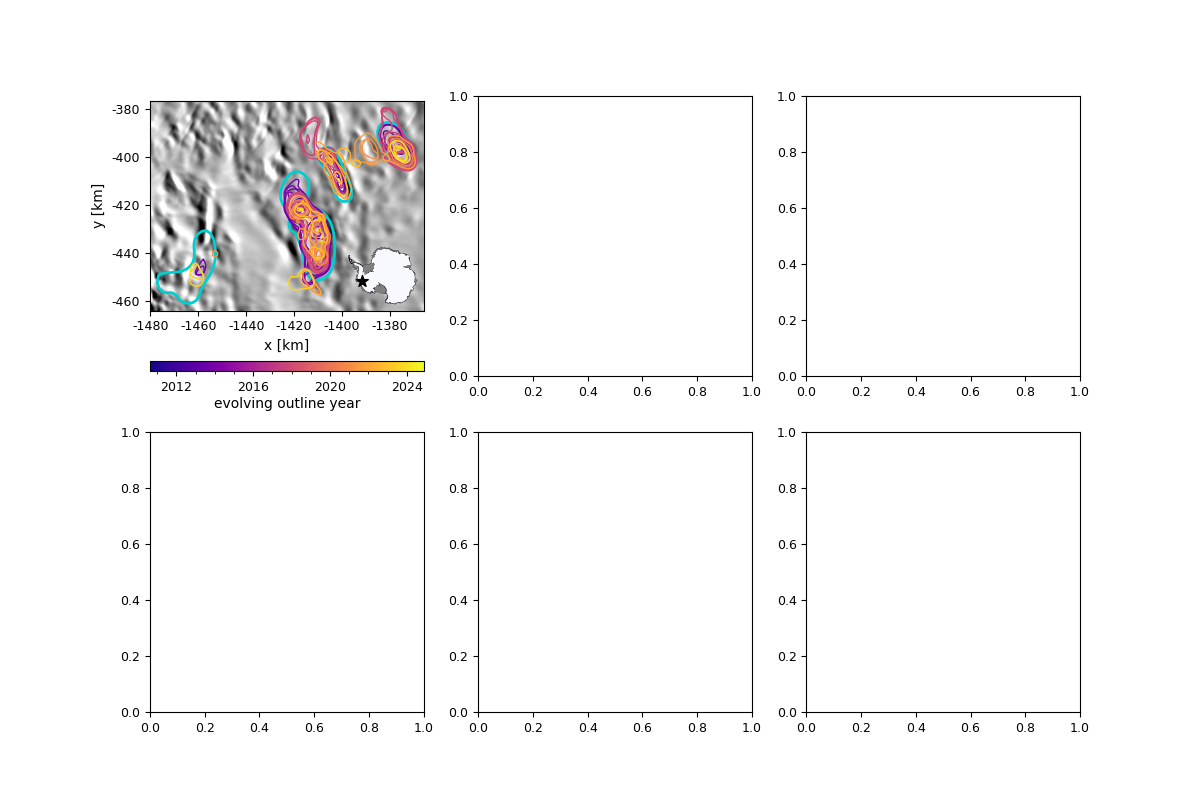

In [38]:
# Final figure
lake_groups = [('Thwaites', ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170'])]

for group_idx, (group_name, lake_list) in enumerate(lake_groups):
    print(f"\nProcessing lake group: {group_name})")
    
    # Lists to store valid lake data
    valid_lakes = []
    evolving_outlines_gdfs = []
    geom_calcs_dfs = []
    lake_gdfs = []
    
    # First pass: collect all valid lake data
    for lake_name in lake_list:
        print(f"Checking data for {lake_name}...")
        
        # Get lake data from stationary outlines
        lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake_name]
        if lake_gdf.empty:
            print(f"Skipping {lake_name}: not found in stationary outlines")
            continue
            
        # Try loading evolving outlines
        try:
            evolving_outlines_gdf = gpd.read_file(os.path.join(
                OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines',
                f'{lake_name}.geojson'))
        except Exception as e:
            print(f"Skipping {lake_name}: no evolving outlines file")
            continue
            
        # Try loading geometric calculations
        try:
            evolving_geom_calcs_df = pd.read_csv(os.path.join(
                OUTPUT_DIR_GIT + '/geometric_calcs/evolving_outlines_geom_calc/',
                f'{lake_name}.csv'))
            evolving_geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

            evolving_union_geom_calcs_df = pd.read_csv(os.path.join(
                OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes/',
                f'{lake_name}.csv'))
            evolving_union_geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

            stationary_geom_calcs_df = pd.read_csv(os.path.join(
                OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes/',
                f'{lake_name}.csv'))
            stationary_geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])
        except Exception as e:
            print(f"Skipping {lake_name}: no geometric calculations file")
            continue
        
        print(f"Valid data found for {lake_name}")
        valid_lakes.append(lake_name)
        lake_gdfs.append(lake_gdf)
        evolving_outlines_gdfs.append(evolving_outlines_gdf)
        geom_calcs_dfs.append(geom_calcs_df)
    
    # Skip this group if no valid lakes found
    if not valid_lakes:
        print(f"Skipping group {group_name}: no valid lakes found")
        continue
        
    print(f"\nCreating plots for valid lakes in group {group_name}: {valid_lakes}")

    # Calculate plot layout
    n_lakes = len(valid_lakes)
    n_plots = n_lakes + 2  # Add 2: one for overview, one for combined plot
    n_rows = (n_plots + 2) // 3  # Integer division rounded up for three columns
    
    # Create figure with equal aspect ratio for all subplots
    fig = plt.figure(figsize=(12, 4*n_rows))  # Wider figure for three columns
    
    # Create grid with equal sized squares
    gs = fig.add_gridspec(n_rows, 3, height_ratios=[1]*n_rows)
    
    # Create 2D array of axes
    axs = np.empty((n_rows, 3), dtype=object)
    for row in range(n_rows):
        for col in range(3):
            axs[row, col] = fig.add_subplot(gs[row, col])
            
    # Main spatial overview panel (first subplot)
    ax_main = axs[0, 0]
    
    # Get combined extent for all valid lakes
    x_mins, x_maxs, y_mins, y_maxs = [], [], [], []
    
    for lake_gdf, evolving_outlines_gdf in zip(lake_gdfs, evolving_outlines_gdfs):
        # Load evolving outlines union for extent calculation
        lake_name = lake_gdf['name'].iloc[0]
        evolving_stationary_union_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[
            evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]
        
        # Get extent
        x_min, y_min, x_max, y_max = evolving_stationary_union_gdf['geometry'].bounds.iloc[0]
        buffer_dist = max(x_max - x_min, y_max - y_min) * 0.1
        x_mins.append(x_min - buffer_dist)
        x_maxs.append(x_max + buffer_dist)
        y_mins.append(y_min - buffer_dist)
        y_maxs.append(y_max + buffer_dist)
    
    # Set plot extent
    x_min, x_max = min(x_mins), max(x_maxs)
    y_min, y_max = min(y_mins), max(y_maxs)
    
    # Plot MOA background
    mask_x = (moa_highres_da.x >= x_min) & (moa_highres_da.x <= x_max)
    mask_y = (moa_highres_da.y >= y_min) & (moa_highres_da.y <= y_max)
    moa_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    ax_main.imshow(moa_subset[0,:,:], cmap='gray', clim=[14000, 17000],
                  extent=[x_min, x_max, y_min, y_max])
    
    # Plot stationary outlines
    stationary_color = 'darkturquoise'
    for lake_gdf in lake_gdfs:
        lake_gdf.boundary.plot(ax=ax_main, color=stationary_color, linewidth=2)
    
    # Plot evolving outlines with time-based coloring
    cmap = plt.get_cmap('plasma')
    norm = plt.Normalize(mdates.date2num(mid_cyc_dates[0]), 
                       mdates.date2num(mid_cyc_dates[-1]))
    
    for evolving_outlines_gdf in evolving_outlines_gdfs:
        for idx, row in evolving_outlines_gdf.iterrows():
            color = cmap(norm(mdates.date2num(pd.to_datetime(row['midcyc_datetime']))))
            gpd.GeoSeries(row['geometry']).boundary.plot(
                ax=ax_main, color=color, linewidth=1)

    # Plot inset map
    axIns = axs[0,0].inset_axes([0.7, 0.02, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1)
    axIns.axis('off')
    # Plot star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, color='k', s=75)

    # Format overview axes
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax_main.xaxis.set_major_formatter(ticks_x)
    ax_main.yaxis.set_major_formatter(ticks_y)
    ax_main.set_xlabel('x [km]')
    ax_main.set_ylabel('y [km]')

    # Create colorbar for overview
    divider = make_axes_locatable(ax_main)
    cax = divider.append_axes('bottom', size='5%', pad=0.5)
    
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))
    
    major_years = [2012, 2016, 2020, 2024]
    minor_years = list(range(2011, 2025))
    major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
    minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]
    
    cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
    cbar.set_ticks(major_dates)
    cbar.set_ticklabels(major_years)
    cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
    cbar.set_label('evolving outline year', labelpad=2)

    # Get y axis limits for time series plots
    y_min, y_max = get_overall_y_limits(geom_calcs_dfs)
    
    # Plot individual lakes
    for idx, (lake_name, evolving_geom_calcs_df, evolving_union_geom_calcs_df, stationary_geom_calcs_df) in enumerate(zip(valid_lakes, evolving_geom_calcs_df, evolving_union_geom_calcs_df, stationary_geom_calcs_df)):
        # Calculate current row and column for this lake plot
        current_row = (idx + 1) // 3
        current_col = (idx + 1) % 3
        ax = axs[current_row, current_col]
        
        ax.axhline(0, color='k', linestyle='--')
        
        dates = mdates.date2num(stationary_geom_calcs_df['midcyc_datetime'])

        # Store line segments for multi-colored line in legend
        onlake_lines = []
        for i, dt in enumerate(dates):
            x, y = 1, 1
            onlake_line, = ax.plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), linewidth=2)
            onlake_lines.append(onlake_line)

        # Evolving outlines (multi-colored line)
        x = dates
        y = np.cumsum(np.divide(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
        lc.set_array(x)
        lc.set_linewidth(2)
        ax.add_collection(lc)
        ax.scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

        # Evolving union outline
        ax.plot(dates, 
               np.cumsum(np.divide(evolving_union_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)),
               color='k', linestyle='dashed', label='Evolving union', linewidth=2)
        ax.scatter(dates, 
               np.cumsum(np.divide(evolving_union_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)),
               color='k', s=5)

        # Stationary outline
        ax.plot(dates, 
               np.cumsum(np.divide(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)),
               color=stationary_color, label='Stationary', linewidth=2)
        ax.scatter(dates, 
               np.cumsum(np.divide(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)),
               color=stationary_color, s=5)

        # Bias
        ax.plot(dates,
               np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)),
               color='r', label='Bias', linewidth=2)
        ax.scatter(dates,
               np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)),
               color='r', s=5)
               
        # Format axes
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        ax.xaxis.set_minor_locator(mdates.YearLocator())
        ax.set_xlabel('Year')
        ax.set_title(lake_name)
        
        # Set x and y axes limit
        ax.set_xlim(cyc_start_dates[0], cyc_end_dates[-1])
        ax.set_ylim(y_min, y_max)
        
        # Add legend to first time series plot only
        if idx == 0:
            stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=2)
            bias_line = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)
            legend = ax.legend([tuple(onlake_lines),
                              stationary_line,
                              bias_line],
                             ['evolving outlines', 
                              'stationary outline',
                              'bias (evolving − stationary)'], 
                             handlelength=3,
                             handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
                             loc='lower center')

    # Plot combined data in the last panel
    last_row = (n_plots - 1) // 3
    last_col = (n_plots - 1) % 3
    ax = axs[last_row, last_col]
    
    ax.axhline(0, color='k', linestyle='--')
    
    # Combine and sum all geometric calculations
    if geom_calcs_dfs:
        combined_df = pd.concat(geom_calcs_dfs)
        summed_df = combined_df.groupby('midcyc_datetime').sum().reset_index()
        dates = mdates.date2num(summed_df['midcyc_datetime'])
    
        # Plot combined volume changes
        ax.plot(dates,
            np.cumsum(np.divide(summed_df['stationary_outline_dV_corr (m^3)'], 1e9)),
            color=stationary_color, linewidth=2)
        ax.scatter(dates,
            np.cumsum(np.divide(summed_df['stationary_outline_dV_corr (m^3)'], 1e9)),
            color=stationary_color, s=5)

        # Plot multi-colored line and scatter for data points
        x = dates
        y = np.cumsum(np.divide(summed_df['evolving_outlines_dV_corr (m^3)'], 1e9))
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
        lc.set_array(x)
        lc.set_linewidth(2)
        line = ax.add_collection(lc)
        scatter = ax.scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)
        
        ax.plot(dates,
            np.cumsum(np.divide(summed_df['bias_dV_corr (m^3)'], 1e9)),
            color='r', linewidth=2)
        ax.scatter(dates,
            np.cumsum(np.divide(summed_df['bias_dV_corr (m^3)'], 1e9)),
            color='r', linewidth=2, s=5)
    
    # Format combined plot axes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_minor_locator(mdates.YearLocator())
    ax.set_xlabel('Year')
    ax.set_title('Summed')
    ax.set_ylim(y_min, y_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(cyc_start_dates[0], cyc_end_dates[-1])

    # # Handle y-axis formatting based on column position
    # if idx % 3 == 0:  # Left column
    #     ax.set_ylabel('Cumulative dV [km$^3$]')
    # else:  # Middle and right columns
    #     ax.set_yticklabels([])  # Remove y-axis tick labels

    # Add common elements
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            # Set common tick parameters
            axs[i,j].tick_params(axis='both')
            
            # Add subplot labels (a, b, c, etc.)
            axs[i,j].text(0.02, 0.98, chr(97 + i*3 + j), transform=axs[i,j].transAxes,
                         fontsize=16, va='top', ha='left')
            
            if (i == 0 and j == 1) or (i == 1 and j == 0):  # targets axs[0,1] and axs[1,0]
                axs[i,j].set_ylabel('Cumulative dV [km$^3$]')
            elif j in [1, 2]:  # Other columns
                axs[i,j].set_yticklabels([])

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Save the figure using the group name
    # sanitized_group_name = group_name.replace(' ', '_').replace('/', '_')
    # plt.savefig(f'{OUTPUT_DIR}/fig4/{sanitized_group_name}.png', 
    #            dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()
    # Clear output
    clear_output(wait=True)

In [35]:
plt.close('all')

## Fig. S2

working on Institute_E1
working on Mac2
working on Site_BC
working on Slessor_23


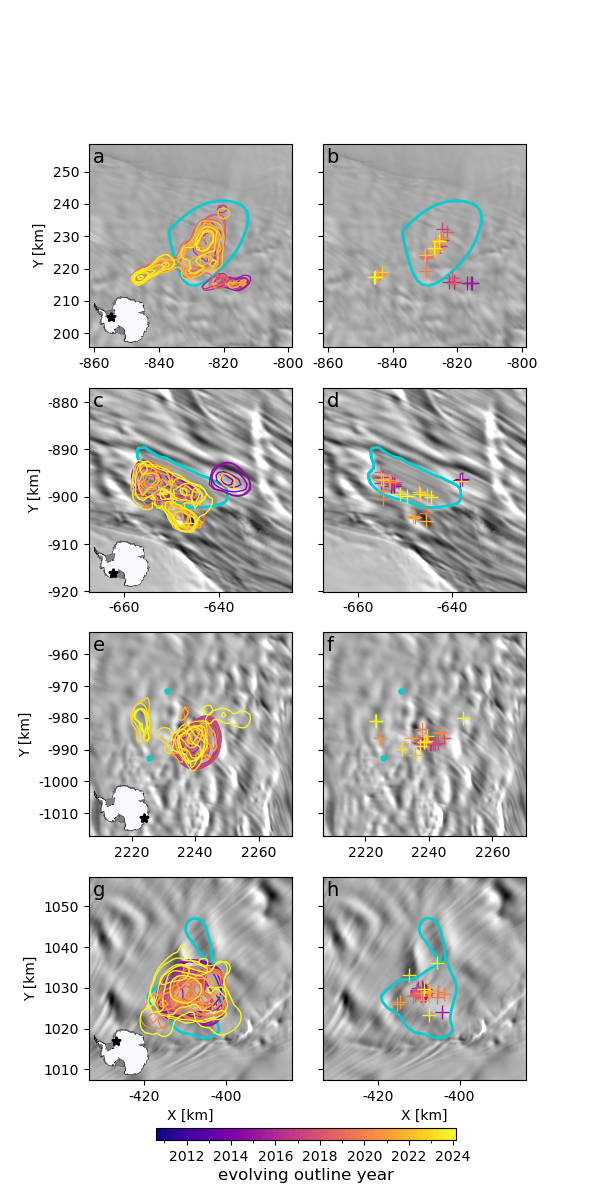

In [63]:
# Select lakes to be included in plot
selected_lakes = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(['Institute_E1', 'Mac2', 'Site_BC', 'Slessor_23'])]
desired_order = ['Institute_E1', 'Mac2', 'Site_BC', 'Slessor_23']
stationary_outlines_gdf_filtered = gpd.GeoDataFrame(pd.concat([selected_lakes[selected_lakes['name'] == name] for name in desired_order]))

# Number of rows and columns (4 lakes, 2 columns - one for outlines, one for centroids)
nrows, ncols = 4, 2

# Create a 4x2 grid of plots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 12), constrained_layout=False)

# Define colors and linestyles for legend
stationary_outline_color = 'darkturquoise'
stationary_line = plt.Line2D([], [], color=stationary_outline_color, linestyle='solid', linewidth=2)
evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=2)

# Set up colormap for temporal evolution
cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
norm = plt.Normalize(mdates.date2num(mid_cyc_dates[0]), 
                    mdates.date2num(mid_cyc_dates[-1]))

for row in range(1, nrows):
    # Share y-axis within each row but not between rows
    for col in range(ncols):
        axs[row, col].sharey(axs[row, 0])

# Process each lake sequentially
for row, lake_name in enumerate(desired_order):
    print('working on {}'.format(lake_name))
    
    # Get the lake data for the current lake
    lake_gdf = stationary_outlines_gdf_filtered[stationary_outlines_gdf_filtered['name'] == lake_name]
    stationary_outline = lake_gdf['geometry']
    
    # Load evolving outlines
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        continue
    
    # Load geometric calculations
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/geometric_calcs/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        print(f"CSV file for {lake_name} not found. Skipping...")
        continue
    
    # Convert strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])
    
    # Use evolving-stationary union outline to find max bounds of plot
    evolving_stationary_union_gdf = evolving_stationary_outlines_union_all_lakes_gdf[
        evolving_stationary_outlines_union_all_lakes_gdf['name'] == lake_name]
    x_min, y_min, x_max, y_max = evolving_stationary_union_gdf.bounds.iloc[0]
    
    # Make plots uniform size and square
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    x_span = x_max - x_min
    y_span = y_max - y_min
    max_span = max(x_span, y_span)
    
    # Update bounds to ensure square dimensions
    x_min = x_mid - max_span / 2
    x_max = x_mid + max_span / 2
    y_min = y_mid - max_span / 2
    y_max = y_mid + max_span / 2
    
    # Add buffer around the plot
    buffer_frac = 0.35
    x_buffer = abs(x_max-x_min) * buffer_frac
    y_buffer = abs(y_max-y_min) * buffer_frac
    
    # Create empty lists to store centroid coordinates
    centroids_x = []
    centroids_y = []
    centroid_dates = []
    
    # Plot both outline and centroid views
    for col in [0, 1]:
        # Plot MOA surface imagery for both columns
        mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
        mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
        moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
        axs[row, col].imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], 
                           extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

        # Plot stationary outline in both columns
        if lake_name == 'Site_BC':
            # Plot both Site_B and Site_C outlines
            for site in ['Site_B', 'Site_C']:
                # stationary_outlines_gdf[stationary_outlines_gdf['name'] == site]['geometry'].boundary.plot(
                #     ax=axs[row, col], 
                #     color=stationary_outline_color, 
                #     linewidth=2
                # )

                # Calculate centroid
                centroid = stationary_outlines_gdf[stationary_outlines_gdf['name'] == site]['geometry'].iloc[0].centroid
        
                # Plot centroids
                axs[row, col].scatter(centroid.x, centroid.y, 
                                   c=stationary_outline_color,
                                   marker='.', s=50, linewidth=1, zorder=2)

        else:
            # Original code for other lakes
            stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake_name]['geometry'].boundary.plot(
                ax=axs[row, col], 
                color=stationary_outline_color, 
                linewidth=2
            )
    
    # Plot evolving outlines with colors based on date (left column only)
    lines = []
    for dt_idx, dt in enumerate(mid_cyc_dates):
        # Create line for legend
        x, y = 1, 1
        line, = axs[row, 0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[dt_idx]))))
        lines.append(line)
        
        # Plot evolving outlines for this time slice
        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
        if not evolving_outlines_gdf_dt_sub.empty:
            # Plot outline in left column
            evolving_outlines_gdf_dt_sub.boundary.plot(
                ax=axs[row, 0], 
                color=cmap(norm(mdates.date2num(mid_cyc_dates[dt_idx]))), 
                linewidth=1
            )
            
            # Calculate and store centroid
            centroid = evolving_outlines_gdf_dt_sub.geometry.iloc[0].centroid
            centroids_x.append(centroid.x)
            centroids_y.append(centroid.y)
            centroid_dates.append(dt)
    
    # Plot centroids in right column
    axs[row, 1].scatter(centroids_x, centroids_y, 
                       c=[cmap(norm(mdates.date2num(dt))) for dt in centroid_dates],
                       marker='+', s=100, linewidth=1, zorder=2)
    
    # Set the same limits and formatting for both plots
    for col in [0, 1]:
        # Format axis ticks to show kilometers
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        axs[row, col].xaxis.set_major_formatter(ticks_x)
        axs[row, col].yaxis.set_major_formatter(ticks_y)
        
        # Set axes limits
        axs[row, col].set(xlim=(x_min-x_buffer, x_max+x_buffer), 
                         ylim=(y_min-y_buffer, y_max+y_buffer))
        
        # Remove y-tick labels for right column only
        if col == 1:
            plt.setp(axs[row, col].get_yticklabels(), visible=False)
        
        axs[3, col].set_xlabel('X [km]')        
        axs[row, 0].set_ylabel('Y [km]')
        # axs[row, 0].set_ylabel(f'{lake_name}\n\nY [km]')

    # Create and style inset map (only for left column)
    axIns = axs[row, 0].inset_axes([0.01, -0.01, 0.3, 0.3])
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    
    # Add location marker to inset map
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                 linewidth=2, color='k', s=30, zorder=3)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        # Add subplot labels (a, b, c, etc.)
        axs[i,j].text(0.02, 0.98, chr(97 + i*2 + j), transform=axs[i,j].transAxes, 
                     fontsize=14, va='top', ha='left')

# Create colorbar at the bottom of the figure
m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))

# Add the colorbar in a new axis below the subplots
cax = fig.add_axes([0.26, 0.05, 0.5, 0.01])  # [left, bottom, width, height]

# Define major and minor years
major_years = [2012, 2014, 2016, 2018, 2020, 2022, 2024]
minor_years = list(range(2011, 2025))
major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]

# Create and customize the colorbar
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_ticks(major_dates)
cbar.set_ticklabels(major_years)
cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
cbar.set_label('evolving outline year', size=12, labelpad=3)

# Adjust the layout to make room for the colorbar
plt.subplots_adjust(bottom=0.1, wspace=0.01)

plt.show()

In [59]:
plt.close('all')